<h1 style="text-align: center;">[“Analisis Kasus Tidak Tap-Out Transjakarta”]</h1>
<h3 style="text-align: center;">[Fransiska Sri Mayawi]</h3>

---

# **Section 1. Business Context**

## **1.1 Context**

Transjakarta menggunakan sistem tap-in/tap-out untuk memantau perjalanan, menghitung tarif, dan merencanakan operasional.
Namun, terdapat kasus penumpang tidak melakukan tap-out, baik karena error sistem (gate, jaringan, bug) atau perilaku penumpang.

Masalah ini dapat:
* Mengurangi akurasi data perjalanan (rute & arus penumpang).
* Mengganggu perhitungan pendapatan (potensi kerugian atau overcharge).
* Meningkatkan komplain penumpang (saldo berkurang, tarif default).
* Menyulitkan Tim IT/QA dan Operasional untuk perbaikan sistem dan perencanaan.
* Analisis ini dilakukan agar Transjakarta dapat mengidentifikasi pola error, prioritaskan perbaikan gate dan sistem, dan meningkatkan kepuasan serta kepercayaan pengguna.

---

## **1.2 Problem Statement & Key Objective**

1. **Mengukur proporsi perjalanan yang tidak tap-out**  
   - Menghitung persentase kasus *tidak tap-out* terhadap total perjalanan.  
   - Menyertakan **confidence interval 95%** untuk memastikan proporsi ini signifikan secara statistik.

2. **Mengidentifikasi "5 halte asal" dengan jumlah insiden tidak tap-out tertinggi**  
   - Menampilkan **jumlah dan persentase insiden per halte**.  
   - Memetakan **titik rawan** untuk investigasi teknis.

3. **Menganalisis distribusi insiden berdasarkan segmen pelanggan**  
   - Membandingkan insiden berdasarkan **kategori usia** (*Anak-anak, Remaja, Dewasa, Pra-Lansia, Lansia*).  
   - Membandingkan insiden berdasarkan **jenis kartu pembayaran** (*TapCash, Brizzi, JakCard, e-Money, Flazz, QRIS*).  
   - Menggunakan **uji Chi-square atau proporsi** untuk menguji signifikansi perbedaan antar segmen.

4. **Menganalisis perbedaan insiden pada jenis layanan bus**  
   - Membandingkan proporsi insiden pada **layanan Reguler, Royaltrans, dan Mikrotrans**.  
   - Menggunakan **uji Chi-square** untuk mendeteksi perbedaan signifikan.

5. **Mengidentifikasi 3 koridor dengan jumlah insiden tidak tap-out tertinggi**  
   - Menampilkan **jumlah insiden per koridor** untuk mendeteksi **rute yang paling bermasalah**.

6. **Menguji hubungan antara insiden tidak tap-out dengan error pembayaran (payAmount kosong)**  
   - Menggunakan **uji Chi-square atau korelasi** untuk mengetahui apakah kedua anomali ini saling terkait.

7. **Menganalisis pola waktu insiden dalam periode 1 bulan**  
   - **Distribusi harian** (jumlah & persentase per hari), membandingkan **weekday vs weekend**.  
   - **Distribusi per jam operasional**, membedakan **jam sibuk (06:00–09:00, 16:00–19:00)** vs **jam non-sibuk**.  
   - Deteksi **hari dengan insiden outlier** menggunakan **Z-score dan IQR**.  
   - Menyediakan **visualisasi tren waktu** untuk mendukung analisis.

   ---



# **Section 2. Data Understanding**

## **2.1 General Information**

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
from scipy import stats


import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')  #menghindari warning dari py agar output bersih

#mengatur agar data yg didisplay ditampilkan sesuai dengan jumlah baris/kolom yg diinginkan
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('display.max_colwidth',2000)
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', 500)

In [2]:
df = pd.read_csv('Transjakarta1.csv')
display(df.head(3), df.tail(3))

,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStops,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStops,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
0,EIIW227B8L34VB,180062659848800,emoney,Bajragin Usada,M,2008,5,Matraman Baru - Ancol,1.0,P00142,Pal Putih,-6.184631,106.84402,7,2023-04-03 05:21:44,P00253,Tegalan,-6.203101,106.85715,12.0,2023-04-03 06:00:53,3500.0
1,LGXO740D2N47GZ,4885331907664776,dki,Gandi Widodo,F,1997,6C,Stasiun Tebet - Karet via Patra Kuningan,0.0,B01963P,Kemenkes 2,-6.228700,106.83302,13,2023-04-03 05:42:44,B03307P,Sampoerna Strategic,-6.217152,106.81892,21.0,2023-04-03 06:40:01,3500.0
2,DJWR385V2U57TO,4996225095064169,dki,Emong Wastuti,F,1992,R1A,Pantai Maju - Kota,0.0,B00499P,Gg. Kunir II,-6.133132,106.81435,38,2023-04-03 05:59:06,B04962P,Simpang Kunir Kemukus,-6.133731,106.81475,39.0,2023-04-03 06:50:55,3500.0


,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStops,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStops,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
37897,YXPP627N4G95HO,213159426675861,emoney,drg. Zahra Nashiruddin,F,1976,1T,Cibubur - Balai Kota,1.0,B02873P,Plaza Sentral,-6.216247,106.81676,12,2023-04-04 10:29:47,B00226P,Buperta Cibubur,-6.370321,106.89628,14.0,2023-04-04 13:27:25,20000.0
37898,RGVK175U2U98UV,377840859133591,emoney,Ana Agustina,M,1976,JAK.13,Tanah Abang - Jembatan Lima,1.0,B02505P,Museum Textile,-6.188656,106.80954,33,2023-04-15 19:59:26,B01787P,JPO Blok G,-6.188861,106.81135,34.0,2023-04-15 20:27:50,0.0
37899,FMZZ963S4B68ZP,501862539795,flazz,drg. Leo Najmudin,F,1985,13,Ciledug - Tendean,0.0,P00001,Adam Malik,-6.236466,106.74786,2,2023-04-12 21:08:12,P00106,Kebayoran Lama,-6.238340,106.77752,7.0,2023-04-12 21:34:53,3500.0


In [3]:
print("General Info")
print("Jumlah baris :", df.shape[0])
print("Jumlah kolom :", df.shape[1])

General Info
Jumlah baris : 37900
Jumlah kolom : 22


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37900 entries, 0 to 37899
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transID           37900 non-null  object 
 1   payCardID         37900 non-null  int64  
 2   payCardBank       37900 non-null  object 
 3   payCardName       37900 non-null  object 
 4   payCardSex        37900 non-null  object 
 5   payCardBirthDate  37900 non-null  int64  
 6   corridorID        36643 non-null  object 
 7   corridorName      35970 non-null  object 
 8   direction         37900 non-null  float64
 9   tapInStops        36687 non-null  object 
 10  tapInStopsName    37900 non-null  object 
 11  tapInStopsLat     37900 non-null  float64
 12  tapInStopsLon     37900 non-null  float64
 13  stopStartSeq      37900 non-null  int64  
 14  tapInTime         37900 non-null  object 
 15  tapOutStops       35611 non-null  object 
 16  tapOutStopsName   36556 non-null  object

In [5]:
pd.set_option('display.max_colwidth', None)
# data uni di tiap kolom
listItem = []
for col in df.columns :
    listItem.append( [col, df[col].nunique(), df[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=listItem)
tabel1Desc

,Column Name,Number of Unique,Unique Sample
0,transID,37900,"[EIIW227B8L34VB, LGXO740D2N47GZ, DJWR385V2U57TO, JTUZ800U7C86EH, VMLO535V7F95NJ, DDES630K2F80KC, HEMW326B9N91TV, XTKE052E5E87LN, OIHS248V7S72EB, ERXO372B2H63RB, CLWK627W2M22WO, IIEK980X1O23NZ, OPLW560U3S06UG, XESX233R4U46DN, LZFD368Q3E81HJ, KLUN542I2F21PI, XDMP644Z5Y29DB, CUPO258C0D42PY, SBPQ144H4S45RA, ZYRL615G4C05RD, MEFW094B7A84RS, ZJVI960B9I42DA, RJPK085I1K65HR, TFIO518N2X54UT, SYLN486U0E02TA, BECP746A8C28NV, KYNP204W3G29VA, MSFD430X8W13TO, MKND874X1D96HF, LFYJ535S2I30DP, TCKQ601Q5O01BC, KQIA358G2N38CX, RANO576G1J87EO, NZCE828E4J23AW, OFPJ170M5O75AP, LKXU174O1E59EP, AXTN077R7Z77JM, WQXL397G5U61OY, RLLZ887W3V14WZ, JJEK861K6E37KF, UANX737M9L25GI, VUWZ891M7I57EB, CXLW459Z3A28RD, AQPU510X2X44PT, BRUT293K1O98GA, MMEX885R3T18QL, UNFK619O2R74DX, FTGY161E2O14MG, ELVU605Z3W26IF, KPDA909R2T72GD, GIHF067H1Y81IV, IXJW013G5W79VX, PKAM574R5S22UG, IQBJ843C4G34DE, SRIX686S0S08SW, MLTY652D7F29HW, NICD824U6H93DE, YEOK544W1J67OX, OPNL705D9K64FN, KHKM512K0T88LD, RHUT145C1U25ZY, TWAK265Z0M88QR, JQIF022K9P74RM, MQCN972F9X71NY, KINJ335N6L86YT, TDIY341Y5S79UU, TFRA396G6W78PD, GXOP506G9B61EP, XESL868N6A66XN, IVHH403J9T51JH, OTGH855B8A29BP, YJMS457L2O20JF, NNAE999Q4V92XM, UCMI767D7M79GS, ZHFN555D9L05LU, WHTZ386I9S44YF, VHUC320U1S58CB, DBWI728C0M55ND, HHCJ093F0W41XK, JUNS207R4F95UA, LFIW578V8Y12XO, GYVC538M6B25WO, QRFR658M6P01AH, TKQW976R2D32RY, PCGM443G2W62OB, PEGV120E5W96OH, BUQT197K3D65PN, UNSO267V8F26WP, RHCN069U6G42WD, QMHC825R0K38KM, WGRY331M3O87VE, TKRV681O2S46RW, ELFD362R2U94NT, YYXK265F5N59SE, ZGJG301G9Z71AR, KNSE319Q1P35CC, RMJF585F2W51BQ, KFYK655N1H73XS, WTBE175B2A58NC, SVRH922T8G79FY, ...]"
1,payCardID,2000,"[180062659848800, 4885331907664776, 4996225095064169, 639099174703, 570928206772, 2251412124634980, 213155822653833, 3587341902618993, 6510013988638519, 3580401035990896, 5541851157087967, 347204308990092, 3536759468239783, 6575130739600630, 4056836188316, 4532407180860336, 4556326832434362836, 4969284110642, 502034641014, 5430018591726410, 378872365541693, 343851798729291, 676293109036, 213191293100137, 2295833910329055, 4968156435384914, 676367323901, 4384653483539395, 213155309116759, 4682220924642, 3589380857722689, 4394677357168120, 4905734029265594, 379334845079777, 346910704516122, 2247096843683316, 675990206087, 639040388584, 4947438345710982, 3539535695881465, 574726750023, 344303671677311, 3544931989278653, 4017802962833960, 5465310774429054, 347394043585982, 4723250872219869, 3545499820365948, 2718070346782735, 342531623551844, 349944373495091, 4428582927102421723, 566171543168, 213121690546749, 3527853482331808, 5542490449138301, 4380875529452127, 4172238784006231, 340065298083181, 4268640600849949, 4290559479079, 213155263532652, 4294484188649274, 180057903365395, 3551174827324245, 340858239719917, 3569562588766630, 180016859215889, 373945281501952, 5134532253940704, 3549158005951908, 379764016867073, 4189640459822695962, 4766007569419196, 3576239635494729, 587887634588, 567286069354, 4097122165824, 378851219912235, 180022972730457, 2237440645700724, 6011162006507240, 4730280883020443501, 3505707886664931, 4450403105752326, 4074114259011835374, 4000041838802, 4112330548313, 30583455954585, 3537543297101185, 2720484776954605, 3570422408611549, 2291402671071407, 676172975739, 180020791350481, 502072062834, 30385017224303, 6590854673757012, 4963710913075879668, 213104805015669, ...]"
2,payCardBank,6,"[emoney, dki, flazz, online, brizzi, bni]"
3,payCardName,1993,"[Bajragin Usada, Gandi Widodo, Emong Wastuti, Surya Wacana, Embuh Mardhiyah, Tirta Siregar, R. Devi Hariyah, S.T., Darmanto Rajasa, Cagak Maheswara, S.Sos, T. Dadap Pradana, M.Ak, Oskar Widiastuti, S.Farm, R.M. Labuh Laksmiwati, Shakila Maryadi, Danuja Usada, Nadine Utami, H. Lutfan Nurdiyanti, Sari Nababan, Hj. Ophelia Haryanti, S.Sos, Adikara Kurniawan, S.Sos, Karna Waskita, Aslijan Irawan, Garang Utama, Fathonah Saefullah, Darman Purwanti, Taufik Farida, Martana Suartini, Eluh Nugroho, Cut Hana Maulana,

In [6]:
# Hitung jumlah data null per kolom
null_counts = df.isnull().sum()

# Hitung persentase data null
null_percent = (null_counts / len(df)) * 100

# Gabungkan jadi satu tabel
null_summary = pd.DataFrame({
    'Jumlah Null': null_counts,
    'Persentase Null (%)': null_percent.round(2)
})

# Filter hanya kolom yang memiliki missing values
null_summary = null_summary[null_summary['Jumlah Null'] > 0].sort_values(by='Persentase Null (%)', ascending=False)

null_summary


,Jumlah Null,Persentase Null (%)
tapOutStops,2289,6.04
corridorName,1930,5.09
tapOutTime,1344,3.55
tapOutStopsName,1344,3.55
tapOutStopsLat,1344,3.55
tapOutStopsLon,1344,3.55
stopEndSeq,1344,3.55
corridorID,1257,3.32
tapInStops,1213,3.20
payAmount,1007,2.66


## Data Null

### Interpretasi & Kemungkinan Penyebab

1. Kolom tap-out data: `tapOutTime`, `tapOutStopsName`, `tapOutStopsLat/Lon` banyak yang null
**Interpretasi:**
- Menandakan penumpang tidak melakukan tap-out atau sistem gagal merekam tap-out.
- Berdampak pada perhitungan tarif (tarif default) dan akurasi data perjalanan.

**Kemungkinan Penyebab:**
- Penumpang lupa atau sengaja tidak tap-out.
- Halte tujuan tidak memiliki atau alat tap-out rusak.
- Gangguan jaringan atau bug sistem yang membuat transaksi tidak tersimpan.
- Penumpang keluar melalui jalur darurat (tidak melalui gate resmi).

2. Kolom `payCard`, `tapInTime`, `tapInStops` juga memiliki data hilang.
**Interpretasi:**
- Transaksi tidak lengkap sejak awal, sehingga perjalanan tidak bisa direkam secara utuh.
- Data ini krusial untuk menentukan koridor dan halte.

**Kemungkinan Penyebab:**
- Pengguna menggunakan metode pembayaran atau kartu yang tidak terintegrasi.
- Kartu gagal terbaca saat tap-in (tapi bus tetap digunakan).
- Error pada alat tap-in atau server yang menyebabkan transaksi tidak terekam.
- Ada kemungkinan data terpotong saat ETL (proses pembersihan awal).

3. Kolom `corridorID` dan `corridorName` ikut kosong.
**Interpretasi:**
- Informasi koridor biasanya diturunkan dari tap-in dan tap-out. Jika salah satunya kosong, sistem tidak bisa mengenali koridor.

**Kemungkinan Penyebab:**
- Transaksi tidak lengkap (tap-in atau tap-out hilang).
- Koridor belum terdaftar di sistem (misal rute baru atau uji coba).
- Data migrasi belum sempurna (mapping koridor ke halte tidak lengkap).

4. Kolom `payAmount`, `stopEndSeq` juga Null
**Interpretasi:**
- payAmount kosong → kemungkinan besar terkait kasus tap-out hilang, sehingga tarif tidak dapat dihitung (sistem biasanya menarik tarif default jika tap-out gagal).
- stopEndSeq kosong → menandakan urutan halte tujuan tidak terekam, biasanya karena data tap-out tidak tersedia atau rute tidak berhasil dipetakan.

**Kemungkinan Penyebab:**
- Error sinkronisasi data tarif atau rute (misalnya data halte tujuan tidak tercatat dengan benar).
- Perjalanan berhenti sebelum tap-out (bus rusak, penumpang turun darurat, atau keluar jalur resmi).
- Kesalahan pada proses pengolahan data (ETL) atau adanya data yang rusak/korup saat impor.

---

### Deskripsi Umum Dataset Transjakarta :
Secara umum, kita bisa melihat bahwa:
1. Dataset Transjakarta memiliki 22 kolom dan 37.900 baris data transaksi perjalanan penumpang.

2. Beberapa kolom memiliki data kosong (missing values), terutama pada:
- corridorID (missing ~3.3%)
- corridorName (missing ~5%)
- tapInStops, tapOutStops, tapOutStopsName, tapOutStopsLat, tapOutStopsLon, stopEndSeq, tapOutTime, dan payAmount (missing ~3–7%).
- Kehilangan data ini kemungkinan besar disebabkan oleh pengguna tidak tap-out, sistem error, atau rute khusus.
3. Kolom transID adalah ID unik untuk setiap transaksi. Kolom ini tidak mengandung informasi analitik, tetapi bisa dipertahankan sebagai identifikasi baris.
4. Kolom payCardID, payCardName, payCardSex, dan payCardBirthDate merepresentasikan identitas pengguna. Semua kolom ini tidak mengandung null dan berpotensi digunakan untuk segmentasi pengguna, meskipun payCardName bisa ambigu karena nama yang sama dapat digunakan oleh beberapa individu berbeda.
5. Kolom direction bertipe float64, padahal hanya memuat nilai diskrit (0 dan 1). Ini bisa dikonversi ke tipe Int64 atau kategori karena merepresentasikan arah perjalanan (misalnya 0 = pergi, 1 = pulang).
6. Kolom tapInTime dan tapOutTime masih bertipe objek (object), sehingga perlu dikonversi ke datetime agar dapat digunakan untuk analisis waktu perjalanan, jam sibuk, dan durasi.
7. Kolom koordinat seperti tapInStopsLat, tapInStopsLon, tapOutStopsLat, tapOutStopsLon sudah bertipe float64 dan relevan jika ingin memetakan persebaran rute, halte, atau visualisasi spasial.
8. Kolom payAmount memiliki nilai numerik dan hanya sedikit missing. Nilai yang muncul seperti 0 (gratis), 3500 (tarif reguler), dan 20000 (premium) masih masuk akal dan menunjukkan sistem tarif.
9. Kolom stopStartSeq dan stopEndSeq berisi urutan halte. Namun, kolom ini seringkali tidak lengkap (misalnya stopEndSeq ada missing), dan penggunaannya perlu ditinjau kembali.
10. Beberapa kolom seperti tapInStops dan tapOutStops berisi kode halte, sedangkan tapInStopsName dan tapOutStopsName berisi nama halte. Nama halte jauh lebih interpretatif sehingga lebih berguna untuk analisis dan visualisasi.
11. Tidak ada kesalahan ketik eksplisit yang terdeteksi, namun bisa jadi beberapa kolom kategorikal seperti corridorName atau payCardBank memiliki variasi ejaan yang perlu distandarkan (misalnya penggunaan huruf kapital tidak konsisten).

---

## **2.2 Feature Information**

Data Set yang kita miliki :

In [7]:
feature_description = {
    'transID''\t''\t': 'ID unik untuk setiap transaksi penumpang',
    'payCardID''\t''\t': 'ID utama kartu pelanggan yang digunakan untuk tap masuk dan tap keluar',
    'payCardBank''\t''\t': 'Bank penerbit kartu',
    'payCardName''\t''\t': 'Nama pemilik kartu seperti yang tertulis pada kartu',
    'payCardSex''\t''\t': 'Jenis kelamin pemilik kartu',
    'payCardBirthDate''\t': 'Tahun lahir pemilik kartu',
    'corridorID''\t''\t': 'ID koridor atau rute Transjakarta (sebagai kunci pengelompokan rute)',
    'corridorName''\t''\t': 'Nama koridor/rute yang menunjukkan titik awal dan akhir perjalanan',
    'direction''\t''\t': 'Arah perjalanan (0 = pergi, 1 = pulang)',
    'tapInStops''\t''\t': 'ID halte tap in',
    'tapInStopsName''\t': 'Nama halte tap in',
    'tapInStopsLat''\t''\t': 'Latitude halte tap in',
    'tapInStopsLon''\t''\t': 'Longitude halte tap in',
    'stopStartSeq''\t''\t': 'Urutan halte saat tap in',
    'tapInTime''\t''\t': 'Waktu saat penumpang melakukan tap in (tanggal dan jam)',
    'tapOutStops''\t''\t': 'ID halte tap out',
    'tapOutStopsName''\t': 'Nama halte tap out',
    'tapOutStopsLat''\t': 'Latitude halte tap out',
    'tapOutStopsLon''\t': 'Longitude halte tap out',
    'stopEndSeq''\t''\t': 'Urutan halte saat tap out',
    'tapOutTime''\t''\t': 'Waktu saat penumpang melakukan tap out (tanggal dan jam)',
    'payAmount''\t''\t': 'Jumlah pembayaran oleh penumpang (bisa nol untuk penumpang gratis)'
}

print("Deskripsi Kolom:")
for col, desc in feature_description.items():
    print(f"- {col}: {desc}")

Deskripsi Kolom:
- transID		: ID unik untuk setiap transaksi penumpang
- payCardID		: ID utama kartu pelanggan yang digunakan untuk tap masuk dan tap keluar
- payCardBank		: Bank penerbit kartu
- payCardName		: Nama pemilik kartu seperti yang tertulis pada kartu
- payCardSex		: Jenis kelamin pemilik kartu
- payCardBirthDate	: Tahun lahir pemilik kartu
- corridorID		: ID koridor atau rute Transjakarta (sebagai kunci pengelompokan rute)
- corridorName		: Nama koridor/rute yang menunjukkan titik awal dan akhir perjalanan
- direction		: Arah perjalanan (0 = pergi, 1 = pulang)
- tapInStops		: ID halte tap in
- tapInStopsName	: Nama halte tap in
- tapInStopsLat		: Latitude halte tap in
- tapInStopsLon		: Longitude halte tap in
- stopStartSeq		: Urutan halte saat tap in
- tapInTime		: Waktu saat penumpang melakukan tap in (tanggal dan jam)
- tapOutStops		: ID halte tap out
- tapOutStopsName	: Nama halte tap out
- tapOutStopsLat	: Latitude halte tap out
- tapOutStopsLon	: Longitude halte tap o

## **2.3 Statistics Summary**

In [8]:
# --- STATISTIK DESKRIPTIF (NUMERIK & KATEGORIK) ---
print("Statistik Numerik:")
print(df.describe().T)
print("\n")

print("Statistik Kategorikal:")
print(df.describe(include=['object']).T)
print("\n")


# --- OPSIONAL: Distribusi Nilai Unik ---
print("Distribusi Gender:")
print(df['payCardSex'].value_counts(dropna=False))
print("\n")

print("Distribusi Bank:")
print(df['payCardBank'].value_counts(dropna=False).head(10))
print("\n")

print("Distribusi Koridor:")
print(df['corridorName'].value_counts(dropna=False).head(10))
print("\n")

Statistik Numerik:
                    count          mean           std           min           25%           50%           75%           max
payCardID         37900.0  4.250060e+17  1.321699e+18  6.040368e+10  1.800442e+14  3.507947e+15  4.699023e+15  4.997694e+18
payCardBirthDate  37900.0  1.990089e+03  1.305148e+01  1.946000e+03  1.982000e+03  1.990000e+03  2.001000e+03  2.012000e+03
direction         37900.0  5.006332e-01  5.000062e-01  0.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00
tapInStopsLat     37900.0 -6.214838e+00  5.791123e-02 -6.394973e+00 -6.245863e+00 -6.214587e+00 -6.175528e+00 -6.089429e+00
tapInStopsLon     37900.0  1.068416e+02  6.036945e-02  1.066147e+02  1.068035e+02  1.068348e+02  1.068823e+02  1.070239e+02
stopStartSeq      37900.0  1.357248e+01  1.223762e+01  0.000000e+00  4.000000e+00  1.000000e+01  1.900000e+01  6.800000e+01
tapOutStopsLat    36556.0 -6.214651e+00  5.902203e-02 -6.394973e+00 -6.247225e+00 -6.214718e+00 -6.174736e+00 -6.

#### Interpretasi Summary Statistics
Dari hasil Summary Statistics Data yang ada pada saat ini, kita dapat mengetahui :

**1. General Overview**
- Jumlah total transaksi: 37.900 baris (records).
- Rentang data: (dari tapInTime dan tapOutTime) terlihat ada data pada April 2023.
- Data tap-out yang lengkap: 36.556 (sekitar 1.344 transaksi (3.5%) tidak memiliki tapOutTime).
- Data corridorName kosong: 1.930 baris (5% data), bisa jadi karena masalah input atau sistem.

**2. Statistik Numerik (Insight Utama)**
1. payCardID
- Tipe numerik (mungkin hasil konversi string ID → angka sangat besar).
- Nilai sangat bervariasi (hingga 4.99e+18), sehingga sebaiknya dikonversi kembali ke string karena bukan data numerik murni.

2. payCardBirthDate
- Rata-rata tahun lahir 1990 (kisaran 1946–2012).
- Ada potensi anomali (1946 bisa berarti kartu institusi atau error).
- Koordinat halte (tapInStopsLat/Lon dan tapOutStopsLat/Lon)
- Semua berada sekitar Jakarta (-6.x latitude, 106.x longitude).
- Tidak ada anomali ekstrem (semua wajar).

3. payAmount
- Rata-rata: Rp 2.699, median: Rp 3.500 (tarif standar Transjakarta).
- Nilai minimum 0 (bisa karena promo atau error).
- Nilai maksimum Rp 20.000 → kemungkinan penalti tarif default untuk yang tidak tap-out.

4. stopStartSeq & stopEndSeq
- Ada 0 (bisa berarti halte awal belum terisi) hingga 68–77 → kemungkinan error input atau rute panjang.

**4. Statistik Kategorikal (Insight Utama)**
1. Bank Kartu Terbanyak
- DKI (JakCard) mendominasi (18.743 transaksi, ~50%).
- Diikuti oleh e-money Mandiri (6.866), Brizzi (3.531), Flazz (3.234).

2. Gender Penumpang
- Perempuan sedikit lebih banyak (F: 20.157, M: 17.743).
- Bisa dianalisis apakah ada perbedaan perilaku tidak tap-out.

3. Koridor Terbanyak (Top 5)
- "Cibubur - Balai Kota" (391), "Ciputat - CSW" (383), dll.
- Tapi ada 1.930 data tanpa corridorName, bisa jadi karena tidak tap-out atau error input.

4. Halte Terbanyak (Top Tap-In)
- Penjaringan (243 tap-in terbanyak).
- Untuk tap-out, halte BKN paling tinggi (316).
- Bisa dicek apakah halte ini juga punya error tap-out tinggi.

**4. Masalah yang Teridentifikasi**
- 3.5% transaksi tanpa tap-out (potensi kasus utama analisis).
- 5% data tanpa corridorName (bisa terkait error tap-out).
- ID kartu (payCardID) salah format → harus dikonversi ke string.
- payAmount 0 dan 20.000 → perlu dianalisis sebagai promo atau penalti.
- Nilai stopStartSeq & stopEndSeq ekstrem (0 atau sangat tinggi) → cek validitasnya.

---

## **Section 3. Data Cleaning**

#### Perbaikan Format Data dan Values

Berdasarkan temuan pada tahap Data Understanding, terdapat beberapa kolom penting yang memiliki missing values (lihat penjelasan pada bagian sebelumnya).
Sebelum melanjutkan ke tahapan penanganan missing values dan pembersihan data lainnya, langkah pertama yang akan dilakukan adalah:
1. Menghapus kolom yang tidak relevan atau tidak diperlukan untuk analisis ini.
2. Memperbaiki format tipe data agar sesuai dengan konteks analisis (misalnya konversi tanggal, ID kartu menjadi string, dan sebagainya).
Langkah ini bertujuan agar dataset lebih ringkas, konsisten, dan siap diproses pada tahap pembersihan berikutnya.

**1. Drop Kolom yang tidak diperlukan**
**Kolom yang Dibutuhkan:**
1. Identitas Transaksi & Pengguna
- `transID` → identifikasi transaksi.
- `payCardID` → untuk analisis pengguna/kartu unik.
- `payCardBank` → analisis jenis kartu (mandiri, BCA, DKI, dll).

2. Profil Dasar Penumpang (Opsional untuk segmentasi)
- `payCardSex`
- `payCardBirthDate` (untuk hitung usia).

3. Informasi Rute dan Halte
- `corridorID`, `corridorName` → analisis koridor dengan kasus terbanyak.
- `tapInStopsName` → lokasi tap-in.
- `tapOutStopsName` → lokasi tap-out (untuk mendeteksi error).

4. Informasi Waktu
- `tapInTime`, `tapOutTime` → untuk tren waktu, jam sibuk, dan menghitung durasi perjalanan.

5. Pembayaran
- `payAmount` → untuk mendeteksi kasus tarif default (kerugian).

**Drop Kolom yang Tidak Diperlukan**

Dalam konteks analisis fokus pada kasus *tidak tap-out*, ada beberapa kolom yang tidak relevan atau redundan untuk digunakan, sehingga dihapus untuk menyederhanakan dataset:

1. **Kolom teknis urutan halte dan arah rute**:  
   - `stopStartSeq`, `stopEndSeq`, `direction`  
   (tidak digunakan dalam perhitungan error atau tren waktu).

2. **Kolom data pribadi dan kode halte**:  
   - `payCardName`, `tapInStops`, `tapOutStops`  
   (data pribadi dan kode halte tidak interpretatif, lebih jelas gunakan nama halte).

3. **Kolom koordinat geografis (latitude/longitude)**:  
   - `tapInStopsLat`, `tapInStopsLon`, `tapOutStopsLat`, `tapOutStopsLon`  
   (analisis ini tidak membuat visualisasi peta, sehingga tidak dibutuhkan).

4. **`corridorID`**:  
   - Redundan karena sudah ada `corridorName` yang lebih deskriptif dan informatif, sementara `corridorID` memiliki 3.3% data kosong.

Setelah penghapusan, dataset menjadi lebih ringkas dan fokus pada kolom yang relevan untuk menjawab *problem statements*.

---


In [9]:
# Daftar kolom yang akan dihapus (tidak relevan untuk analisis tap-out)
drop_cols = [
    'stopStartSeq', 'stopEndSeq', 'direction', 
    'payCardName', 'tapInStops', 'tapOutStops',
    'tapInStopsLat', 'tapInStopsLon',   # koordinat tap-in
    'tapOutStopsLat', 'tapOutStopsLon', # koordinat tap-out
    'corridorID'                        # ID koridor (redundan, pakai corridorName saja)
]

# Hapus kolom yang tidak diperlukan
df.drop(columns=drop_cols, inplace=True, errors='ignore')

# Cek kolom yang tersisa
print("Kolom setelah drop:", df.columns.tolist())
print(f"Total kolom sekarang: {len(df.columns)}")


Kolom setelah drop: ['transID', 'payCardID', 'payCardBank', 'payCardSex', 'payCardBirthDate', 'corridorName', 'tapInStopsName', 'tapInTime', 'tapOutStopsName', 'tapOutTime', 'payAmount']
Total kolom sekarang: 11


In [10]:
# 1. Konversi kolom waktu menjadi datetime
df['tapInTime'] = pd.to_datetime(df['tapInTime'], errors='coerce')
df['tapOutTime'] = pd.to_datetime(df['tapOutTime'], errors='coerce')

# 2. Konversi payCardBirthDate (hanya tahun) jadi integer
df['payCardBirthDate'] = pd.to_numeric(df['payCardBirthDate'], errors='coerce').astype('Int64')

# 4. Konversi kolom kategorikal lainnya
df[['payCardID', 'payCardBank', 'payCardSex', 'corridorName', 
    'tapInStopsName', 'tapOutStopsName']] = df[['payCardID', 'payCardBank', 'payCardSex', 
    'corridorName', 'tapInStopsName', 'tapOutStopsName']].astype('category')

# 5. Pastikan kolom numerik dalam format float
df[['payAmount']] = df[['payAmount']].apply(pd.to_numeric, errors='coerce')

# Cek hasil tipe data
print(df.dtypes)


transID                     object
payCardID                 category
payCardBank               category
payCardSex                category
payCardBirthDate             Int64
corridorName              category
tapInStopsName            category
tapInTime           datetime64[ns]
tapOutStopsName           category
tapOutTime          datetime64[ns]
payAmount                  float64
dtype: object


### Pembuatan Kolom Usia dan Kategori Usia

Berdasarkan kolom `payCardBirthDate` (tahun kelahiran penumpang), dibuat dua kolom baru:

1. **Kolom `usia`**  
   - Dihitung menggunakan rumus:  
     \[
     usia = 2023 - payCardBirthDate
     \]  
   - Menghasilkan usia penumpang pada tahun 2023 (berdasarkan data tapInTime).

2. **Kolom `kategori_usia`**  
   - Berdasarkan rentang usia berikut (dalam Bahasa Indonesia):  
     - **Anak-anak**: usia ≤ 12 tahun  
     - **Remaja**: 13–17 tahun  
     - **Dewasa**: 18–39 tahun  
     - **Pra-Lansia**: 40–59 tahun  
     - **Lansia**: ≥ 60 tahun  
     - Nilai **`Tidak Diketahui`** diberikan untuk baris dengan `payCardBirthDate` yang kosong.

Kedua kolom baru ini ditempatkan **setelah kolom `payCardBirthDate`** agar mudah dilihat berdekatan dengan data tahun lahir.

---

In [11]:
# Membuat kolom 'usia' dan 'kategori_usia' berdasarkan 'payCardBirthDate'
# Perhitungan usia: 2023 - tahun lahir (hanya tahun)

# Hitung usia
df['usia'] = 2023 - df['payCardBirthDate']

# Tentukan kategori usia (dalam Bahasa Indonesia)
def kategori_usia(u):
    if pd.isna(u):
        return 'Tidak Diketahui'
    elif u <= 12:
        return 'Anak-anak'
    elif u <= 17:
        return 'Remaja'
    elif u <= 39:
        return 'Dewasa'
    elif u <= 59:
        return 'Pra-Lansia'
    else:
        return 'Lansia'

df['kategori_usia'] = df['usia'].apply(kategori_usia)

# Pindahkan kolom 'usia' dan 'kategori_usia' agar berada setelah 'payCardBirthDate'
cols = list(df.columns)
pos = cols.index('payCardBirthDate') + 1
for col in ['usia', 'kategori_usia'][::-1]:
    cols.insert(pos, cols.pop(cols.index(col)))
df = df[cols]

# Cek hasil (contoh 10 baris pertama)
print(df[['payCardBirthDate', 'usia', 'kategori_usia']].head(10))


   payCardBirthDate  usia kategori_usia
0              2008    15        Remaja
1              1997    26        Dewasa
2              1992    31        Dewasa
3              1978    45    Pra-Lansia
4              1982    41    Pra-Lansia
5              1993    30        Dewasa
6              1974    49    Pra-Lansia
7              1991    32        Dewasa
8              1992    31        Dewasa
9              2004    19        Dewasa


### Pembuatan Kolom `serviceType` (Jenis Layanan Transjakarta)

Berdasarkan nilai `payAmount`, dibuat kolom baru `serviceType` untuk mengidentifikasi jenis layanan yang digunakan penumpang:

- **Royaltrans**: jika `payAmount` = 20.000  
- **Transjakarta**: jika `payAmount` = 3.500  
- **Mikrotrans**: jika `payAmount` = 0  
- **Lainnya**: jika `payAmount` memiliki nilai selain ketiga kategori di atas (sebagai penanda data anomali atau kasus khusus).

Kolom ini membantu analisis lebih lanjut untuk melihat **apakah kecenderungan tidak tap-out lebih banyak terjadi pada layanan tertentu**.

---

In [12]:
# Membuat kolom 'serviceType' berdasarkan nilai payAmount
def service_type(amount):
    if pd.isna(amount):
        return 'Tidak Diketahui'
    elif amount == 20000:
        return 'Royaltrans'
    elif amount == 3500:
        return 'Transjakarta'
    elif amount == 0:
        return 'Mikrotrans'
    else:
        return 'Lainnya'  # Jika ada tarif lain (anomali atau khusus)

df['serviceType'] = df['payAmount'].apply(service_type)

# Letakkan kolom 'serviceType' setelah 'payAmount'
cols = list(df.columns)
pos = cols.index('payAmount') + 1
cols.insert(pos, cols.pop(cols.index('serviceType')))
df = df[cols]

# Cek hasil (5 baris pertama)
df.tail()

,transID,payCardID,payCardBank,payCardSex,payCardBirthDate,usia,kategori_usia,corridorName,tapInStopsName,tapInTime,tapOutStopsName,tapOutTime,payAmount,serviceType
37895,ZWEC949B8Q87QG,4685818286724028395,brizzi,F,2004,19,Dewasa,Ragunan - MH Thamrin via Semanggi,Tosari,2023-04-21 18:18:37,SMK 57,2023-04-21 19:55:49,3500.0,Transjakarta
37896,YHHK837P6Y95GN,6502902290603767,dki,M,1974,49,Pra-Lansia,Pinang Ranti - Pramuka,Garuda Taman Mini,2023-04-18 21:52:31,Pinang Ranti,2023-04-18 22:28:22,3500.0,Transjakarta
37897,YXPP627N4G95HO,213159426675861,emoney,F,1976,47,Pra-Lansia,Cibubur - Balai Kota,Plaza Sentral,2023-04-04 10:29:47,Buperta Cibubur,2023-04-04 13:27:25,20000.0,Royaltrans
37898,RGVK175U2U98UV,377840859133591,emoney,M,1976,47,Pra-Lansia,Tanah Abang - Jembatan Lima,Museum Textile,2023-04-15 19:59:26,JPO Blok G,2023-04-15 20:27:50,0.0,Mikrotrans
37899,FMZZ963S4B68ZP,501862539795,flazz,F,1985,38,Dewasa,Ciledug - Tendean,Adam Malik,2023-04-12 21:08:12,Kebayoran Lama,2023-04-12 21:34:53,3500.0,Transjakarta


### Pembuatan Kolom Hari Perjalanan

Untuk analisis pola harian (misalnya melihat tren kasus tidak tap-out di hari tertentu), 
dibuat kolom baru `tapInDay` yang diambil dari `tapInTime`.  
Kolom ini menyimpan nama hari (Senin, Selasa, dst.) untuk setiap perjalanan.

Hanya `tapInTime` yang digunakan sebagai acuan karena:
- Kasus tidak tap-out umumnya dianalisis dari waktu masuk (tap-in).
- Mengurangi jumlah kolom agar dataset lebih ringkas.

---

In [13]:
# Pastikan tapInTime sudah bertipe datetime
df['tapInTime'] = pd.to_datetime(df['tapInTime'], errors='coerce')

# Buat kolom nama hari dari tapInTime (dalam Bahasa Indonesia)
df['tapInDay'] = df['tapInTime'].dt.day_name(locale='id_ID')

# Letakkan kolom 'tapInDay' setelah 'tapInTime'
cols = list(df.columns)
pos_in = cols.index('tapInTime') + 1
cols.insert(pos_in, cols.pop(cols.index('tapInDay')))
df = df[cols]

# Cek hasil (5 baris pertama)
print(df[['tapInTime', 'tapInDay']].head())


            tapInTime tapInDay
0 2023-04-03 05:21:44    Senin
1 2023-04-03 05:42:44    Senin
2 2023-04-03 05:59:06    Senin
3 2023-04-03 05:44:51    Senin
4 2023-04-03 06:17:35    Senin


### Normalisasi Kolom `payCardSex`

Kolom `payCardSex` pada dataset awal hanya berisi singkatan:
- `F` untuk perempuan.
- `M` untuk laki-laki.

Agar lebih deskriptif dan mudah dipahami dalam visualisasi maupun analisis, 
nilai pada kolom ini diubah menjadi:
- `Female` untuk `F`
- `Male` untuk `M`

---

In [14]:
# Ubah value kolom payCardSex menjadi 'Female' dan 'Male'
df['payCardSex'] = df['payCardSex'].replace({
    'F': 'Female',
    'M': 'Male'
})

# Cek hasil distribusi
print(df['payCardSex'].value_counts())

payCardSex
Female    20157
Male      17743
Name: count, dtype: int64


### Penambahan Kolom `payCardProduct` dan Penghapusan `payCardBank`

Untuk menyederhanakan dataset, kolom `payCardBank` yang berisi kode bank digantikan dengan 
kolom baru `payCardProduct`.  

Kolom `payCardProduct` menyimpan jenis kartu atau metode pembayaran dalam format yang lebih jelas:
- `dki` → **JakCard**  
- `emoney` → **e-Money**  
- `brizzi` → **Brizzi**  
- `flazz` → **Flazz**  
- `bni` → **TapCash**  
- `online` → **QRIS**  

Kolom `payCardProduct` disisipkan **setelah `payCardID`**, sedangkan `payCardBank` dihapus agar dataset lebih ringkas.

---

In [15]:
# Mapping dan penambahan kolom payCardProduct
df.insert(
    df.columns.get_loc('payCardID') + 1,
    'payCardProduct',
    df['payCardBank'].map({
        'dki': 'JakCard',
        'emoney': 'e-Money',
        'brizzi': 'Brizzi',
        'flazz': 'Flazz',
        'bni': 'TapCash',
        'online': 'QRIS'
    })
)

# Hapus kolom payCardBank karena sudah digantikan
df = df.drop(columns='payCardBank')

# Cek hasil
print(df[['payCardID', 'payCardProduct']].head())


          payCardID payCardProduct
0   180062659848800        e-Money
1  4885331907664776        JakCard
2  4996225095064169        JakCard
3      639099174703          Flazz
4      570928206772          Flazz


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37900 entries, 0 to 37899
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transID           37900 non-null  object        
 1   payCardID         37900 non-null  category      
 2   payCardProduct    37900 non-null  category      
 3   payCardSex        37900 non-null  category      
 4   payCardBirthDate  37900 non-null  Int64         
 5   usia              37900 non-null  Int64         
 6   kategori_usia     37900 non-null  object        
 7   corridorName      35970 non-null  category      
 8   tapInStopsName    37900 non-null  category      
 9   tapInTime         37900 non-null  datetime64[ns]
 10  tapInDay          37900 non-null  object        
 11  tapOutStopsName   36556 non-null  category      
 12  tapOutTime        36556 non-null  datetime64[ns]
 13  payAmount         36893 non-null  float64       
 14  serviceType       3790

**3.1 Missing Values**

In [17]:
# Hitung jumlah data null per kolom
null_counts = df.isnull().sum()

# Hitung persentase data null
null_percent = (null_counts / len(df)) * 100

# Gabungkan jadi satu tabel
null_summary = pd.DataFrame({
    'Jumlah Null': null_counts,
    'Persentase Null (%)': null_percent.round(2)
})

# Filter hanya kolom yang memiliki missing values
null_summary = null_summary[null_summary['Jumlah Null'] > 0].sort_values(by='Persentase Null (%)', ascending=False)

null_summary


,Jumlah Null,Persentase Null (%)
corridorName,1930,5.09
tapOutStopsName,1344,3.55
tapOutTime,1344,3.55
payAmount,1007,2.66


### Penanganan Missing Values pada Kolom `corridorName`

Kolom `corridorName` penting karena digunakan untuk analisis **koridor mana yang memiliki insiden tidak tap-out terbanyak**.  
Dari hasil pengecekan, ditemukan sekitar **5.09% nilai kosong** pada kolom ini.

Jika baris dengan nilai kosong dihapus, akan ada pengurangan data yang cukup signifikan (lebih dari 5%) dan bisa menimbulkan bias pada analisis.  
Oleh karena itu, **lebih baik dilakukan imputasi** dengan menambahkan kategori baru:

- **Kategori baru:** `"Tidak Diketahui"`
- **Alasan:**  
  - Mempertahankan seluruh data agar tidak kehilangan sampel.
  - Memastikan semua perjalanan tetap terhitung dalam agregasi.
  - Tetap bisa digunakan dalam visualisasi dan analisis perbandingan.

Setelah imputasi, kolom `corridorName` akan **bersih dari missing values** dan siap digunakan dalam analisis.

---

In [18]:
# Imputasi missing values pada corridorName dengan kategori "Tidak Diketahui"
df['corridorName'] = df['corridorName'].cat.add_categories(['Tidak Diketahui'])
df['corridorName'] = df['corridorName'].fillna('Tidak Diketahui')

# Cek hasil setelah imputasi
print(df['corridorName'].isna().sum())  # Harus 0
print(df['corridorName'].value_counts().head())

0
corridorName
Tidak Diketahui                            1930
Cibubur - Balai Kota                        391
Ciputat - CSW                               383
Pulo Gadung - Monas                         343
Harmoni - Jakarta International Stadium     338
Name: count, dtype: int64


### Penanganan Missing Value pada `tapOutStopsName`

Kolom `tapOutStopsName` berisi informasi nama halte saat penumpang melakukan tap-out.
Sebanyak 3,55% data pada kolom ini bernilai null.

Karena fokus analisis adalah mengidentifikasi **insiden tidak tap-out**, kolom ini **tidak akan diimputasi**.  
Nilai null justru digunakan sebagai indikator utama untuk mendeteksi perjalanan yang tidak lengkap.  

Langkah berikutnya:
- Tandai baris dengan `tapOutStopsName` bernilai null sebagai **kasus tidak tap-out**.
- Gunakan kolom ini dalam analisis per halte, koridor, dan waktu.

---

In [19]:
# Membuat flag untuk mendeteksi perjalanan tanpa data halte tujuan
df['isNoTapOutStop'] = df['tapOutStopsName'].isna()

# Statistik jumlah dan persentase
total_no_tapout_stop = df['isNoTapOutStop'].sum()
percentage_no_tapout_stop = df['isNoTapOutStop'].mean() * 100

print(f"Jumlah perjalanan tanpa tap-out stop: {total_no_tapout_stop}")
print(f"Persentase perjalanan tanpa tap-out stop: {percentage_no_tapout_stop:.2f}%")

Jumlah perjalanan tanpa tap-out stop: 1344
Persentase perjalanan tanpa tap-out stop: 3.55%


### Penanganan Missing Value pada `tapOutTime`

Kolom `tapOutTime` mencatat waktu penumpang melakukan tap-out di halte tujuan.
Sebanyak 3,55% data pada kolom ini bernilai null.

Karena fokus analisis adalah mendeteksi **kasus perjalanan tidak tap-out**, 
kolom ini **tidak akan diimputasi**.  
Sebaliknya, nilai null digunakan sebagai indikator untuk membuat flag khusus `isNoTapOut`, 
yang menandai perjalanan yang tidak memiliki tap-out time.

Langkah:
- Membuat kolom boolean `isNoTapOut` (True jika `tapOutTime` bernilai null).
- Menggunakan flag ini untuk analisis seperti persentase kasus, distribusi halte, dan tren waktu.

---

In [20]:
# Membuat flag untuk mendeteksi perjalanan tanpa tap-out time
df['isNoTapOut'] = df['tapOutTime'].isna()

# Statistik jumlah dan persentase
total_no_tapout = df['isNoTapOut'].sum()
percentage_no_tapout = df['isNoTapOut'].mean() * 100

print(f"Jumlah perjalanan tanpa tap-out time: {total_no_tapout}")
print(f"Persentase perjalanan tanpa tap-out: {percentage_no_tapout:.2f}%")


Jumlah perjalanan tanpa tap-out time: 1344
Persentase perjalanan tanpa tap-out: 3.55%


### Penanganan Missing Value pada `payAmount`

Kolom `payAmount` berisi jumlah tarif perjalanan.  
Sebanyak 2,66% data bernilai null, yang biasanya disebabkan oleh:
- Penumpang tidak melakukan tap-out sehingga tarif tidak bisa dihitung.
- Error sistem pada pencatatan pembayaran.

Kolom ini **tidak akan diimputasi**, karena nilai null menjadi indikator penting untuk mendeteksi kasus **anomali pembayaran**.

Sebagai gantinya:
- Dibuat kolom flag `isNoPay` untuk menandai transaksi tanpa tarif.
- Flag ini dapat membantu analisis hubungan antara **kasus tidak tap-out** dengan **error pembayaran**.

---

In [21]:
# Membuat flag untuk mendeteksi perjalanan tanpa pembayaran
df['isNoPay'] = df['payAmount'].isna()

# Statistik jumlah dan persentase
total_no_pay = df['isNoPay'].sum()
percentage_no_pay = df['isNoPay'].mean() * 100

print(f"Jumlah perjalanan tanpa pembayaran: {total_no_pay}")
print(f"Persentase perjalanan tanpa pembayaran: {percentage_no_pay:.2f}%")

Jumlah perjalanan tanpa pembayaran: 1007
Persentase perjalanan tanpa pembayaran: 2.66%


In [22]:
df.head()

,transID,payCardID,payCardProduct,payCardSex,payCardBirthDate,usia,kategori_usia,corridorName,tapInStopsName,tapInTime,tapInDay,tapOutStopsName,tapOutTime,payAmount,serviceType,isNoTapOutStop,isNoTapOut,isNoPay
0,EIIW227B8L34VB,180062659848800,e-Money,Male,2008,15,Remaja,Matraman Baru - Ancol,Pal Putih,2023-04-03 05:21:44,Senin,Tegalan,2023-04-03 06:00:53,3500.0,Transjakarta,False,False,False
1,LGXO740D2N47GZ,4885331907664776,JakCard,Female,1997,26,Dewasa,Stasiun Tebet - Karet via Patra Kuningan,Kemenkes 2,2023-04-03 05:42:44,Senin,Sampoerna Strategic,2023-04-03 06:40:01,3500.0,Transjakarta,False,False,False
2,DJWR385V2U57TO,4996225095064169,JakCard,Female,1992,31,Dewasa,Pantai Maju - Kota,Gg. Kunir II,2023-04-03 05:59:06,Senin,Simpang Kunir Kemukus,2023-04-03 06:50:55,3500.0,Transjakarta,False,False,False
3,JTUZ800U7C86EH,639099174703,Flazz,Female,1978,45,Pra-Lansia,Pulo Gebang - Pulo Gadung 2 via PIK,Taman Elok 1,2023-04-03 05:44:51,Senin,Raya Penggilingan,2023-04-03 06:28:16,3500.0,Transjakarta,False,False,False
4,VMLO535V7F95NJ,570928206772,Flazz,Male,1982,41,Pra-Lansia,Tanjung Priok - Pluit,Sunter Boulevard Barat,2023-04-03 06:17:35,Senin,Kali Besar Barat,2023-04-03 06:57:03,3500.0,Transjakarta,False,False,False


In [23]:
# Buat flag apakah tapOutTime kosong (indikasi tidak tap-out)
df['isNoTapOut'] = df['tapOutTime'].isna()

# Buat flag apakah payAmount kosong
df['isNoPay'] = df['payAmount'].isna()

# Cek kombinasi kasus (cross-tab)
summary_check = pd.crosstab(df['isNoTapOut'], df['isNoPay'], 
                             rownames=['Tidak Tap-Out'], 
                             colnames=['PayAmount Kosong'])

print(summary_check)

# Tampilkan jumlah kasus detail
print("\nRincian:")
print(f"1. Tidak Tap-Out & Pay Kosong      : {summary_check.loc[True, True]}")
print(f"2. Tidak Tap-Out & Pay TERISI      : {summary_check.loc[True, False]}")
print(f"3. Tap-Out Ada & Pay Kosong        : {summary_check.loc[False, True]}")
print(f"4. Tap-Out Ada & Pay TERISI        : {summary_check.loc[False, False]}")


PayAmount Kosong  False  True 
Tidak Tap-Out                 
False             35588    968
True               1305     39

Rincian:
1. Tidak Tap-Out & Pay Kosong      : 39
2. Tidak Tap-Out & Pay TERISI      : 1305
3. Tap-Out Ada & Pay Kosong        : 968
4. Tap-Out Ada & Pay TERISI        : 35588


**3.2 Duplicated Values**

In [24]:
# --- 1. Flag untuk duplikasi berdasarkan transID (harus unik) ---
df['isDupTransID'] = df.duplicated(subset='transID', keep=False)

# --- 2. Flag untuk duplikasi penuh (baris identik) ---
df['isDupFull'] = df.duplicated(keep=False)

# --- 3. Flag untuk duplikasi Tap-In (kartu + waktu + halte sama) ---
df['isDupTapIn'] = df.duplicated(subset=['payCardID', 'tapInTime', 'tapInStopsName'], keep=False)

# --- Statistik ringkasan ---
print("Jumlah duplikasi berdasarkan transID:", df['isDupTransID'].sum())
print("Jumlah duplikasi penuh (baris identik):", df['isDupFull'].sum())
print("Jumlah duplikasi Tap-In (kartu + waktu + halte sama):", df['isDupTapIn'].sum())


Jumlah duplikasi berdasarkan transID: 0
Jumlah duplikasi penuh (baris identik): 0
Jumlah duplikasi Tap-In (kartu + waktu + halte sama): 0


**Pemeriksaan Duplikasi Data**

Setelah dilakukan pemeriksaan terhadap tiga jenis duplikasi berikut:
1. **Duplikasi berdasarkan `transID`** – untuk memastikan setiap transaksi memiliki ID unik.
2. **Duplikasi penuh (baris identik)** – untuk mendeteksi baris yang sepenuhnya sama.
3. **Duplikasi Tap-In (kartu + waktu + halte sama)** – untuk mengecek potensi *double tap* atau error pada perangkat.

Hasil pemeriksaan:
- **Jumlah duplikasi berdasarkan `transID`**: **0**
  - Setiap transaksi memiliki ID unik, tidak ada pencatatan ganda pada level transaksi.
  - Menandakan kualitas data untuk identifikasi transaksi sudah baik.

- **Jumlah duplikasi penuh (baris identik)**: **0**
  - Tidak ada baris yang sepenuhnya identik dengan baris lain.
  - Dataset bersih dari *redundansi* akibat kesalahan ETL atau penggabungan data.

- **Jumlah duplikasi Tap-In (kartu + waktu + halte sama)**: **0**
  - Tidak ditemukan kasus *double tap* atau kesalahan perangkat pada proses tap-in.
  - Data transaksi tap-in dapat dipercaya tanpa indikasi error perangkat.

Dataset **bebas dari duplikasi**, sehingga tidak diperlukan pembersihan tambahan untuk duplikasi.

---


**3.3 Identify Spelling Errors**

**Identifikasi dan Normalisasi Spelling Errors pada Kolom Kategorikal**

Kolom **`corridorName`**, **`tapInStopsName`**, dan **`tapOutStopsName`** berisi nama koridor dan halte yang dapat mengandung:
- Variasi ejaan (misalnya "Cawang UKI" vs "Cawang Uki").
- Perbedaan kapitalisasi huruf (besar/kecil).
- Spasi ganda atau karakter yang tidak konsisten.

Agar hasil analisis akurat, langkah yang dilakukan:
1. **Identifikasi jumlah nilai unik** dan contoh nilai untuk mendeteksi perbedaan.
2. **Normalisasi format penulisan**:
   - Semua huruf diubah menjadi **title case** (contoh: `cawang uki` → `Cawang Uki`).
   - Hilangkan **spasi berlebih** (contoh: `Cawang   Uki` → `Cawang Uki`).
   - Jika ditemukan ejaan yang mirip atau salah, kita bisa menyatukan secara manual.

Berikut kode untuk melakukan pengecekan dan normalisasi:


In [25]:
# Daftar kolom kategorikal yang akan dicek dan dinormalisasi
cat_cols = ['corridorName', 'tapInStopsName', 'tapOutStopsName']

# Langkah 1: Cek jumlah nilai unik sebelum normalisasi
for col in cat_cols:
    print(f"\n=== Sebelum Normalisasi: {col} ===")
    print(f"Jumlah nilai unik: {df[col].nunique()}")
    print("Contoh 20 nilai unik pertama:")
    print(df[col].dropna().unique()[:20])

# Langkah 2: Normalisasi penulisan (title case + hapus spasi ganda)
for col in cat_cols:
    # Ubah ke string, hilangkan spasi di awal/akhir, ganti spasi ganda, dan ubah ke Title Case
    df[col] = (
        df[col]
        .astype(str)
        .str.strip()
        .str.replace(r'\s+', ' ', regex=True)
        .str.title()
    )
    # Kembalikan NaN jika sebelumnya memang kosong (bukan string kosong)
    df[col] = df[col].replace('Nan', pd.NA)

# Langkah 3: Cek jumlah nilai unik setelah normalisasi
for col in cat_cols:
    print(f"\n=== Setelah Normalisasi: {col} ===")
    print(f"Jumlah nilai unik: {df[col].nunique()}")
    print("Contoh 20 nilai unik pertama:")
    print(df[col].dropna().unique()[:20])



=== Sebelum Normalisasi: corridorName ===
Jumlah nilai unik: 217
Contoh 20 nilai unik pertama:
['Matraman Baru - Ancol', 'Stasiun Tebet - Karet via Patra Kuningan', 'Pantai Maju - Kota', 'Pulo Gebang - Pulo Gadung 2 via PIK', 'Tanjung Priok - Pluit', ..., 'Ciputat - Kampung Rambutan', 'Ciledug - Tendean', 'Kebayoran Lama - Jelambar', 'Pinang Ranti - Pluit', 'Terminal Tanjung Priok - Ancol Barat']
Length: 20
Categories (217, object): ['Andara - Stasiun Universitas Pancasila', 'BKN - Blok M', 'BSD - Jelambar', 'BSD Serpong - Fatmawati', ..., 'Terminal Tanjung Priok - Ancol Barat', 'Tongtek - Tebet Eco Park (TEP) - Cililitan', 'Universitas Indonesia - Lebak Bulus', 'Tidak Diketahui']

=== Sebelum Normalisasi: tapInStopsName ===
Jumlah nilai unik: 2602
Contoh 20 nilai unik pertama:
['Pal Putih', 'Kemenkes 2', 'Gg. Kunir II', 'Taman Elok 1', 'Sunter Boulevard Barat', ..., 'SMK Darussalam', 'JORR', 'Apartemen Simprug Teras', 'Jembatan Tiga Arah Utara', 'Gunung Sahari Mangga Dua Timur']
Leng

**Kesimpulan Sementara:**

- Tidak ada ejaan kacau besar setelah normalisasi (hanya penyesuaian kapitalisasi dan spasi).
- Untuk analisis kasus tidak tap-out, hasil ini sudah cukup bersih tanpa perlu pemetaan manual lebih lanjut, kecuali kita ingin menggabungkan halte dengan jalur berbeda.

---

**3.4 Identify Anomaly Values**

### Identifikasi Anomali Durasi Perjalanan

Pada tahap ini, kita ingin mendeteksi perjalanan yang memiliki durasi tidak wajar, baik terlalu singkat maupun terlalu lama. Analisis ini penting karena:
- Perjalanan **kurang dari 5 menit** bisa menjadi indikasi kesalahan data (tap-in/tap-out berdekatan) atau perjalanan yang tidak wajar.
- Perjalanan **lebih dari 2 jam (120 menit)** berpotensi menunjukkan kasus *device error* (tap-out terlambat) atau perjalanan yang abnormal.

Langkah-langkah:
1. Hitung durasi perjalanan (dalam menit) dengan mengurangkan `tapInTime` dari `tapOutTime`.
2. Buat flag `isOvertime` untuk menandai perjalanan dengan durasi lebih dari 2 jam.
3. Hitung jumlah perjalanan dengan durasi kurang dari 5 menit tanpa membuat kolom tambahan.
4. Sajikan hasilnya dalam bentuk ringkasan jumlah kasus per kategori.

---

In [26]:
# Hitung durasi perjalanan dalam menit
df['durasi_menit'] = (df['tapOutTime'] - df['tapInTime']).dt.total_seconds() / 60

# Flag perjalanan dengan durasi > 2 jam (overtime)
df['isOvertime'] = df['durasi_menit'] > 120

# Hitung jumlah perjalanan dengan durasi < 5 menit (tanpa kolom tambahan)
short_trips_count = (df['durasi_menit'] < 5).sum()

# Buat ringkasan anomali durasi
anomali_summary = pd.DataFrame({
    'Kategori': ['Durasi < 5 Menit', 'Durasi > 2 Jam'],
    'Jumlah Perjalanan': [short_trips_count, df['isOvertime'].sum()]
})

# Tampilkan ringkasan
display(anomali_summary)

# Cek contoh perjalanan overtime (5 baris pertama)
print(df[df['isOvertime']][['durasi_menit', 'tapInTime', 'tapOutTime']].head())


,Kategori,Jumlah Perjalanan
0,Durasi < 5 Menit,0
1,Durasi > 2 Jam,105


       durasi_menit           tapInTime          tapOutTime
37600    159.633333 2023-04-30 17:08:35 2023-04-30 19:48:13
37604    130.800000 2023-04-14 05:40:20 2023-04-14 07:51:08
37605    162.816667 2023-04-06 06:03:19 2023-04-06 08:46:08
37607    136.416667 2023-04-03 06:24:11 2023-04-03 08:40:36
37608    163.216667 2023-04-17 09:19:15 2023-04-17 12:02:28


### Identifikasi Nilai Pembayaran (payAmount) yang Tidak Valid

Kolom `payAmount` seharusnya hanya memiliki tiga nilai tarif resmi:
- **0** untuk Mikrotrans (gratis/tarif nol),
- **3.500** untuk Transjakarta reguler,
- **20.000** untuk Royaltrans.

Langkah:
1. Cek distribusi nilai unik pada kolom `payAmount`.
2. Deteksi nilai yang tidak termasuk dalam daftar resmi.
3. Hasilkan ringkasan jumlah transaksi dengan nilai valid dan anomali.

---

In [27]:
# Daftar tarif resmi
valid_tariffs = [0, 3500, 20000]

# Distribusi nilai unik pada payAmount
print("Distribusi Nilai Unik payAmount:")
print(df['payAmount'].value_counts(dropna=False).sort_index())

# Deteksi nilai tarif yang tidak valid (bukan 0, 3500, atau 20000)
invalid_tariffs = df[~df['payAmount'].isin(valid_tariffs) & df['payAmount'].notna()]

# Hitung jumlah dan persentase anomali
total_transaksi = len(df)
jumlah_anomali = len(invalid_tariffs)
persentase_anomali = (jumlah_anomali / total_transaksi) * 100

print(f"\nJumlah transaksi dengan nilai tarif tidak valid: {jumlah_anomali} "
      f"({persentase_anomali:.2f}% dari total {total_transaksi} transaksi)")

Distribusi Nilai Unik payAmount:
payAmount
0.0        16648
3500.0     18503
20000.0     1742
NaN         1007
Name: count, dtype: int64

Jumlah transaksi dengan nilai tarif tidak valid: 0 (0.00% dari total 37900 transaksi)


### Deteksi Usia Penumpang Tidak Masuk Akal

Pada tahap ini, kita memeriksa data usia penumpang (kolom `usia`) untuk mendeteksi nilai yang tidak mungkin, yang bisa disebabkan oleh kesalahan input data (tahun lahir tidak logis). Dua kondisi anomali yang dicek:

1. **Usia < 0** → Tahun lahir tercatat di masa depan.
2. **Usia > 100** → Sangat tidak mungkin, kemungkinan kesalahan input.

Langkah yang dilakukan:
- Hitung jumlah penumpang dengan usia anomali.
- Hitung persentasenya terhadap total data.
- Tampilkan contoh baris yang mengalami anomali.

Anomali ini akan dianalisis lebih lanjut apakah perlu diperbaiki (imputasi), dikategorikan sebagai *Unknown*, atau dihapus tergantung kebutuhan analisis.

---

In [28]:
# Deteksi usia tidak masuk akal (<0 atau >100)
invalid_usia = df[(df['usia'] < 0) | (df['usia'] > 100)]

# Hitung jumlah dan persentase kasus
total_data = len(df)
jumlah_anomali_usia = len(invalid_usia)
persentase_anomali_usia = (jumlah_anomali_usia / total_data) * 100

print(f"Jumlah penumpang dengan usia tidak masuk akal: {jumlah_anomali_usia} "
      f"({persentase_anomali_usia:.2f}% dari total {total_data} baris)")

Jumlah penumpang dengan usia tidak masuk akal: 0 (0.00% dari total 37900 baris)


### Deteksi Nama Koridor dan Halte yang Tidak Logis

Tahap ini memeriksa apakah terdapat nama koridor atau halte (`corridorName`, `tapInStopsName`, `tapOutStopsName`) yang tidak logis, yang bisa menjadi tanda data dummy atau placeholder. Beberapa pengecekan yang dilakukan:

1. **Nilai "Tidak Diketahui"**  
   - Sudah diimputasi sebelumnya untuk `corridorName`.
   - Dicek ulang untuk memastikan nilainya hanya muncul di kolom yang memang diimputasi.

2. **Nilai Kosong (Null)**  
   - Pastikan tidak ada nilai kosong di kolom nama halte dan koridor setelah proses pembersihan.

3. **Nama Dummy (Tidak Wajar)**  
   - Deteksi nama-nama halte atau koridor yang mengandung kata seperti:  
     `"Test"`, `"Dummy"`, `"XYZ"`, atau pola lain yang tidak relevan.
   - Nama-nama ini biasanya muncul karena kesalahan input atau data uji coba dari sistem.

Langkah berikutnya:
- Jika ada, nilai-nilai dummy akan dianalisis apakah perlu **dihapus**, **diganti dengan "Tidak Diketahui"**, atau **ditandai** sebagai data uji coba.

---

In [29]:
import re

# Daftar kolom yang akan dicek
nama_kolom = ['corridorName', 'tapInStopsName', 'tapOutStopsName']

# Daftar kata kunci untuk mendeteksi nama dummy
dummy_keywords = ['test', 'dummy', 'xyz']

# Fungsi untuk mendeteksi apakah ada dummy keyword
def contains_dummy(name):
    if pd.isna(name):
        return False
    return any(re.search(kw, str(name), re.IGNORECASE) for kw in dummy_keywords)

# Cek masing-masing kolom
for kolom in nama_kolom:
    total_na = df[kolom].isna().sum()
    total_tidak_diketahui = (df[kolom] == 'Tidak Diketahui').sum()
    dummy_entries = df[df[kolom].apply(contains_dummy)][kolom].unique()
    
    print(f"=== Kolom: {kolom} ===")
    print(f"Total NaN: {total_na}")
    print(f"Total 'Tidak Diketahui': {total_tidak_diketahui}")
    print(f"Dummy entries (contoh nama tidak wajar): {list(dummy_entries) if len(dummy_entries)>0 else 'Tidak ada'}")
    print()

=== Kolom: corridorName ===
Total NaN: 0
Total 'Tidak Diketahui': 1930
Dummy entries (contoh nama tidak wajar): Tidak ada

=== Kolom: tapInStopsName ===
Total NaN: 0
Total 'Tidak Diketahui': 0
Dummy entries (contoh nama tidak wajar): Tidak ada

=== Kolom: tapOutStopsName ===
Total NaN: 1344
Total 'Tidak Diketahui': 0
Dummy entries (contoh nama tidak wajar): ['Gereja Protestan Tugu']



In [30]:
df.head()

,transID,payCardID,payCardProduct,payCardSex,payCardBirthDate,usia,kategori_usia,corridorName,tapInStopsName,tapInTime,tapInDay,tapOutStopsName,tapOutTime,payAmount,serviceType,isNoTapOutStop,isNoTapOut,isNoPay,isDupTransID,isDupFull,isDupTapIn,durasi_menit,isOvertime
0,EIIW227B8L34VB,180062659848800,e-Money,Male,2008,15,Remaja,Matraman Baru - Ancol,Pal Putih,2023-04-03 05:21:44,Senin,Tegalan,2023-04-03 06:00:53,3500.0,Transjakarta,False,False,False,False,False,False,39.150000,False
1,LGXO740D2N47GZ,4885331907664776,JakCard,Female,1997,26,Dewasa,Stasiun Tebet - Karet Via Patra Kuningan,Kemenkes 2,2023-04-03 05:42:44,Senin,Sampoerna Strategic,2023-04-03 06:40:01,3500.0,Transjakarta,False,False,False,False,False,False,57.283333,False
2,DJWR385V2U57TO,4996225095064169,JakCard,Female,1992,31,Dewasa,Pantai Maju - Kota,Gg. Kunir Ii,2023-04-03 05:59:06,Senin,Simpang Kunir Kemukus,2023-04-03 06:50:55,3500.0,Transjakarta,False,False,False,False,False,False,51.816667,False
3,JTUZ800U7C86EH,639099174703,Flazz,Female,1978,45,Pra-Lansia,Pulo Gebang - Pulo Gadung 2 Via Pik,Taman Elok 1,2023-04-03 05:44:51,Senin,Raya Penggilingan,2023-04-03 06:28:16,3500.0,Transjakarta,False,False,False,False,False,False,43.416667,False
4,VMLO535V7F95NJ,570928206772,Flazz,Male,1982,41,Pra-Lansia,Tanjung Priok - Pluit,Sunter Boulevard Barat,2023-04-03 06:17:35,Senin,Kali Besar Barat,2023-04-03 06:57:03,3500.0,Transjakarta,False,False,False,False,False,False,39.466667,False


In [31]:
# Export DataFrame ke CSV
df.to_csv('transjakarta_clean.csv', index=False, encoding='utf-8-sig')

## **Section 4. Analytics**

## Distribusi Frekuensi Kategori (Dengan Persentase dan Top 10 Koridor)

Pada tahap ini, kita akan menganalisis distribusi frekuensi dari beberapa kolom kategorikal penting dalam dataset, yaitu:

- **`payCardProduct`** → jenis kartu pembayaran (JakCard, e-Money, Brizzi, Flazz, TapCash, QRIS).  
- **`kategori_usia`** → kategori usia penumpang (Anak-anak, Remaja, Dewasa, Pra-Lansia, Lansia).  
- **`tapInDay`** → hari perjalanan (Senin s.d. Minggu).  
- **`corridorName`** → nama koridor rute perjalanan.

### Langkah Analisis
1. Menghitung distribusi frekuensi (jumlah) dan persentase (%) untuk setiap kategori.  
2. Menyajikan hasil distribusi dalam bentuk tabel agar mudah dianalisis.  
3. Membuat visualisasi berupa **bar chart** untuk mempermudah pemahaman distribusi.  
4. Khusus untuk `corridorName`, hanya ditampilkan **10 koridor teratas** agar visualisasi tidak terlalu padat dan lebih mudah dibaca.

### Tujuan Analisis Distribusi:
- Mengetahui **jenis kartu** pembayaran apa yang paling dominan digunakan.  
- Mengidentifikasi **segmentasi penumpang** berdasarkan kategori usia.  
- Melihat **pola penggunaan layanan** berdasarkan **hari perjalanan**.  
- Mengungkap **koridor-koridor dengan volume perjalanan tertinggi (Top 10)**.

Hasil distribusi akan ditampilkan **baik dalam bentuk tabel (jumlah dan persentase)** maupun **grafik** agar lebih informatif.

---


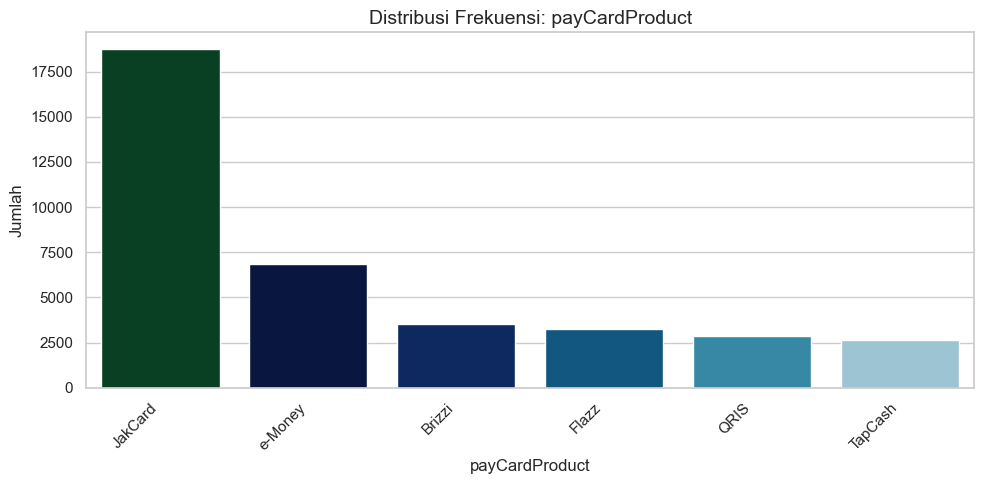


=== Distribusi payCardProduct ===
                Jumlah  Persen (%)
payCardProduct                    
JakCard          18743       49.45
e-Money           6866       18.12
Brizzi            3531        9.32
Flazz             3234        8.53
QRIS              2869        7.57
TapCash           2657        7.01
--------------------------------------------------


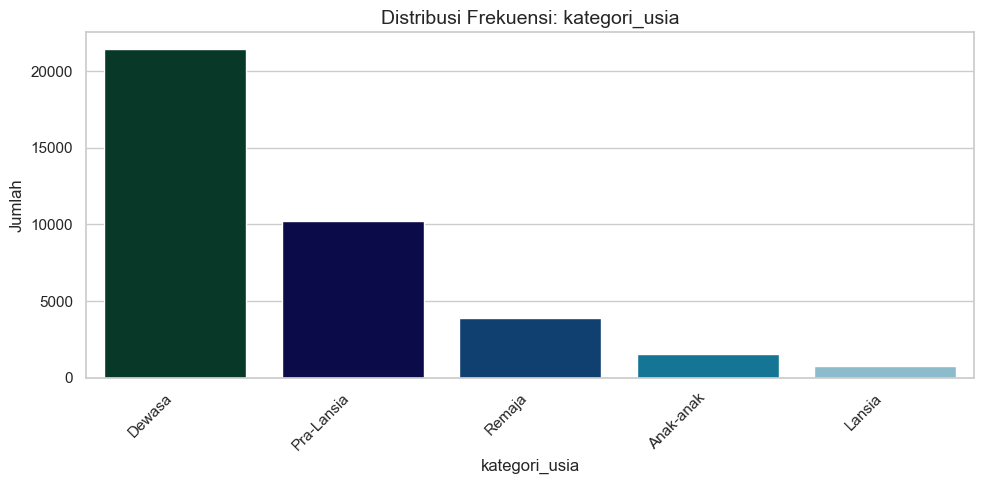


=== Distribusi kategori_usia ===
               Jumlah  Persen (%)
kategori_usia                    
Dewasa          21453       56.60
Pra-Lansia      10253       27.05
Remaja           3882       10.24
Anak-anak        1530        4.04
Lansia            782        2.06
--------------------------------------------------


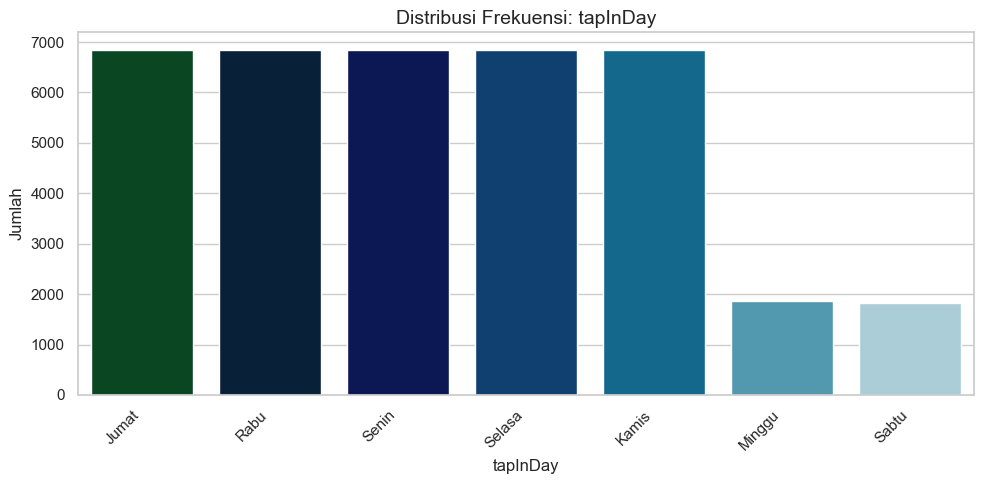


=== Distribusi tapInDay ===
          Jumlah  Persen (%)
tapInDay                    
Jumat       6851       18.08
Rabu        6840       18.05
Senin       6838       18.04
Selasa      6835       18.03
Kamis       6834       18.03
Minggu      1872        4.94
Sabtu       1830        4.83
--------------------------------------------------


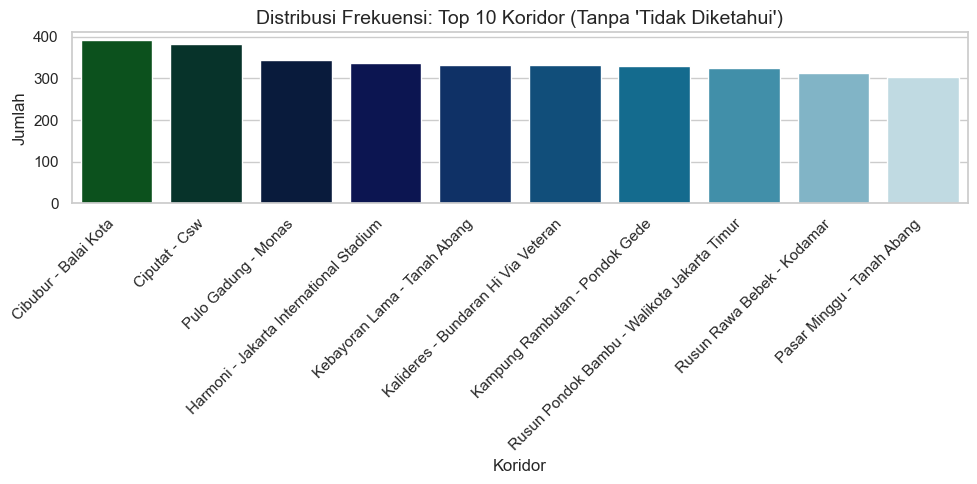


=== Distribusi Top 10 corridorName (Tanpa 'Tidak Diketahui') ===
                                             Jumlah  Persen (%)
corridorName                                                   
Cibubur - Balai Kota                            391        1.09
Ciputat - Csw                                   383        1.06
Pulo Gadung - Monas                             343        0.95
Harmoni - Jakarta International Stadium         338        0.94
Kebayoran Lama - Tanah Abang                    333        0.93
Kalideres - Bundaran Hi Via Veteran             332        0.92
Kampung Rambutan - Pondok Gede                  329        0.91
Rusun Pondok Bambu - Walikota Jakarta Timur     326        0.91
Rusun Rawa Bebek - Kodamar                      312        0.87
Pasar Minggu - Tanah Abang                      303        0.84
--------------------------------------------------


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set gaya visualisasi dengan palet biru (ocean)
sns.set(style="whitegrid")

# Daftar kolom kategorikal untuk analisis
kategori_cols = ['payCardProduct', 'kategori_usia', 'tapInDay', 'corridorName']

# Analisis distribusi
for col in kategori_cols:
    plt.figure(figsize=(10, 5))
    
    # Untuk corridorName, hanya ambil 10 teratas (kecualikan 'Tidak Diketahui')
    if col == 'corridorName':
        filtered_corridors = df[df['corridorName'] != 'Tidak Diketahui']
        top_corridors = filtered_corridors[col].value_counts().nlargest(10)
        
        sns.barplot(
            x=top_corridors.index, 
            y=top_corridors.values, 
            palette=sns.color_palette("ocean", n_colors=len(top_corridors))
        )
        plt.title("Distribusi Frekuensi: Top 10 Koridor (Tanpa 'Tidak Diketahui')", fontsize=14)
        plt.ylabel("Jumlah")
        plt.xlabel("Koridor")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # Print summary (jumlah + persen)
        corridor_summary = pd.DataFrame({
            'Jumlah': top_corridors,
            'Persen (%)': (top_corridors / len(filtered_corridors) * 100).round(2)
        })
        print(f"\n=== Distribusi Top 10 {col} (Tanpa 'Tidak Diketahui') ===")
        print(corridor_summary)
        print("-" * 50)
        
    else:
        order = df[col].value_counts().index
        sns.countplot(
            data=df, 
            x=col, 
            order=order, 
            palette=sns.color_palette("ocean", n_colors=len(order))
        )
        plt.title(f"Distribusi Frekuensi: {col}", fontsize=14)
        plt.ylabel("Jumlah")
        plt.xlabel(col)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # Print summary (jumlah + persen)
        summary = pd.DataFrame({
            'Jumlah': df[col].value_counts(),
            'Persen (%)': (df[col].value_counts(normalize=True) * 100).round(2)
        })
        print(f"\n=== Distribusi {col} ===")
        print(summary)
        print("-" * 50)


## Distribusi Data (Numerik dan Kategorikal)

### 1 Distribusi Data Numerik

Kita akan menganalisis distribusi untuk kolom numerik berikut:

1. **Usia (`usia`)** – distribusi usia penumpang.
2. **Nominal Pembayaran (`payAmount`)** – tarif yang dibayarkan (0, 3.500, 20.000).
3. **Durasi Perjalanan (`durasi_menit`)** – lamanya perjalanan dalam menit.

Langkah yang dilakukan:
- Plot **Histogram** untuk melihat sebaran distribusi.
- Plot **Boxplot** untuk mendeteksi **outlier**.
- Semua grafik dibuat secara berdampingan agar mudah dibandingkan.

Visualisasi ini membantu mendeteksi:
- Apakah ada **usia tidak wajar**.
- Apakah ada **anomali pada tarif pembayaran**.
- Apakah ada **perjalanan dengan durasi yang ekstrem** (outlier).


### 2 Distribusi Data Kategorikal

Pada tahap ini kita menganalisis distribusi frekuensi dari beberapa kolom kategorikal penting:

1. **payCardProduct**  
   Menunjukkan jenis kartu pembayaran yang digunakan (JakCard, e-Money, Brizzi, Flazz, TapCash, QRIS).  
   Analisis ini membantu melihat bank atau produk kartu yang paling dominan.

2. **kategori_usia**  
   Segmentasi penumpang berdasarkan kategori usia (Anak-anak, Remaja, Dewasa, Pra-Lansia, Lansia).  
   Memberikan gambaran kelompok usia mana yang paling sering menggunakan layanan.

3. **tapInDay**  
   Hari perjalanan (Senin s.d. Minggu) untuk melihat pola perjalanan harian.

4. **corridorName (Top 10)**  
   Menampilkan 10 koridor dengan jumlah perjalanan tertinggi.  
   Kategori khusus `Tidak Diketahui` **tidak ditampilkan dalam grafik** agar visualisasi fokus, tetapi **persentase dan jumlahnya tetap dilaporkan di ringkasan** sehingga kita tahu berapa data yang tidak memiliki informasi koridor.

### Tujuan Analisis
Distribusi ini membantu:
- Mengidentifikasi dominasi produk kartu pembayaran.
- Mengetahui segmentasi pengguna berdasarkan usia.
- Melihat distribusi penggunaan layanan berdasarkan hari.
- Menemukan koridor terpopuler berdasarkan volume perjalanan.

### Catatan
Kategori `Tidak Diketahui` pada `corridorName` diperlakukan terpisah:
- Tidak ikut ditampilkan di grafik dan peringkat.
- Jumlah dan persentasenya tetap dilaporkan agar diketahui kontribusinya.


---


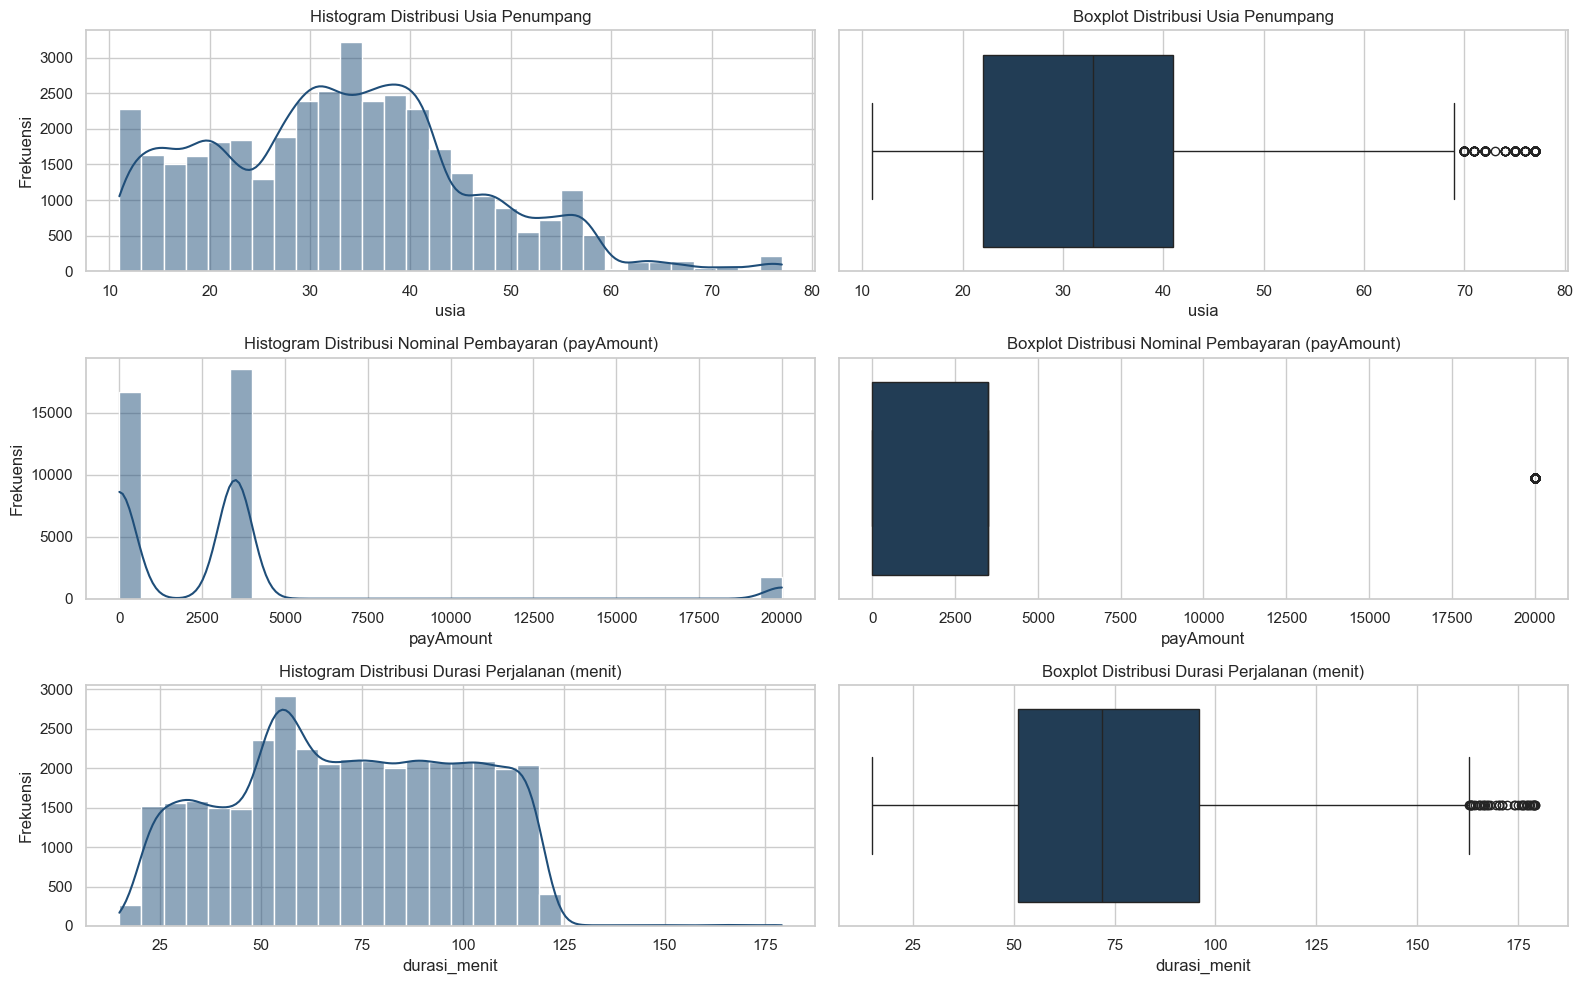

In [33]:
# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(16, 10))

# Kolom numerik yang dianalisis
num_cols = ['usia', 'payAmount', 'durasi_menit']
titles = ['Distribusi Usia Penumpang', 
          'Distribusi Nominal Pembayaran (payAmount)',
          'Distribusi Durasi Perjalanan (menit)']

# Warna biru tua
color_hist = '#1F4E79'  # biru tua untuk histogram
color_box = '#1A3D5D'   # biru tua lebih gelap untuk boxplot

for i, col in enumerate(num_cols, 1):
    # Histogram
    plt.subplot(3, 2, 2*i-1)
    sns.histplot(df[col], bins=30, kde=True, color=color_hist)
    plt.title(f'Histogram {titles[i-1]}', fontsize=12)
    plt.xlabel(col)
    plt.ylabel('Frekuensi')
    
    # Boxplot
    plt.subplot(3, 2, 2*i)
    sns.boxplot(x=df[col], color=color_box)
    plt.title(f'Boxplot {titles[i-1]}', fontsize=12)
    plt.xlabel(col)

plt.tight_layout()
plt.show()


## Analisis Distribusi Variabel Numerik

Kita menganalisis tiga variabel numerik utama:  
1. **Usia Penumpang (`usia`)**  
2. **Nominal Pembayaran (`payAmount`)**  
3. **Durasi Perjalanan (`durasi_menit`)**

### Temuan Distribusi

1. **Usia Penumpang**
   - Mayoritas penumpang berusia **20–40 tahun**, puncak di sekitar **30–35 tahun**.
   - Distribusi **mendekati normal tetapi sedikit right-skewed** karena ada penumpang **>70 tahun (outlier)**.
   - Analisis parametrik (t-test, ANOVA) masih mungkin, tetapi perlu konfirmasi uji normalitas.

2. **Nominal Pembayaran (`payAmount`)**
   - Terdapat **tiga cluster utama**:
     - **0 rupiah** (Mikrotrans/gratis),
     - **3.500 rupiah** (tarif reguler),
     - **20.000 rupiah** (Royaltrans).
   - Distribusi **tidak normal, multimodal, dan right-skewed**.
   - Analisis sebaiknya dilakukan per kelompok tarif dengan **uji non-parametrik**.

3. **Durasi Perjalanan (`durasi_menit`)**
   - Mayoritas perjalanan berada di **50–90 menit**, sebagian kecil **<30 menit** (rute pendek) dan **>150 menit (outlier/overtime)**.
   - Distribusi **right-skewed**, banyak outlier.
   - Deskripsi sebaiknya gunakan **median & IQR**.

### Implikasi Statistik
- Tidak ada variabel yang sepenuhnya berdistribusi normal.
- Gunakan **median, IQR, Spearman correlation, dan uji non-parametrik** (Mann-Whitney/Kruskal-Wallis).
- Lakukan uji normalitas formal (Shapiro-Wilk) untuk konfirmasi.

---

In [34]:
from scipy.stats import shapiro, spearmanr

# Variabel numerik yang dianalisis
num_cols = ['usia', 'payAmount', 'durasi_menit']

# 1. Uji Normalitas (Shapiro-Wilk)
print("=== Uji Normalitas (Shapiro-Wilk) ===")
for col in num_cols:
    # Drop NaN
    data = df[col].dropna()
    stat, p = shapiro(data.sample(5000, random_state=42) if len(data) > 5000 else data)
    print(f"{col}: Statistik={stat:.4f}, p-value={p:.4f}")
    if p > 0.05:
        print(f" -> Data {col} kemungkinan berdistribusi normal (tidak tolak H0)")
    else:
        print(f" -> Data {col} TIDAK berdistribusi normal (tolak H0)")
    print("-" * 50)

# 2. Korelasi Spearman antar variabel numerik
print("\n=== Korelasi Spearman antar Variabel Numerik ===")
for i in range(len(num_cols)):
    for j in range(i+1, len(num_cols)):
        col1, col2 = num_cols[i], num_cols[j]
        corr, p = spearmanr(df[col1], df[col2], nan_policy='omit')
        print(f"Korelasi {col1} vs {col2}: Spearman={corr:.3f}, p-value={p:.4f}")
        if p < 0.05:
            print(" -> Korelasi signifikan secara statistik")
        else:
            print(" -> Tidak ada korelasi signifikan")
        print("-" * 50)


=== Uji Normalitas (Shapiro-Wilk) ===
usia: Statistik=0.9772, p-value=0.0000
 -> Data usia TIDAK berdistribusi normal (tolak H0)
--------------------------------------------------
payAmount: Statistik=0.5083, p-value=0.0000
 -> Data payAmount TIDAK berdistribusi normal (tolak H0)
--------------------------------------------------
durasi_menit: Statistik=0.9680, p-value=0.0000
 -> Data durasi_menit TIDAK berdistribusi normal (tolak H0)
--------------------------------------------------

=== Korelasi Spearman antar Variabel Numerik ===
Korelasi usia vs payAmount: Spearman=-0.075, p-value=0.0000
 -> Korelasi signifikan secara statistik
--------------------------------------------------
Korelasi usia vs durasi_menit: Spearman=0.002, p-value=0.7603
 -> Tidak ada korelasi signifikan
--------------------------------------------------
Korelasi payAmount vs durasi_menit: Spearman=-0.006, p-value=0.2537
 -> Tidak ada korelasi signifikan
--------------------------------------------------



=== Distribusi payCardProduct ===


,Jumlah,Persen (%)
payCardProduct,,
JakCard,18743,49.45
e-Money,6866,18.12
Brizzi,3531,9.32
Flazz,3234,8.53
QRIS,2869,7.57
TapCash,2657,7.01


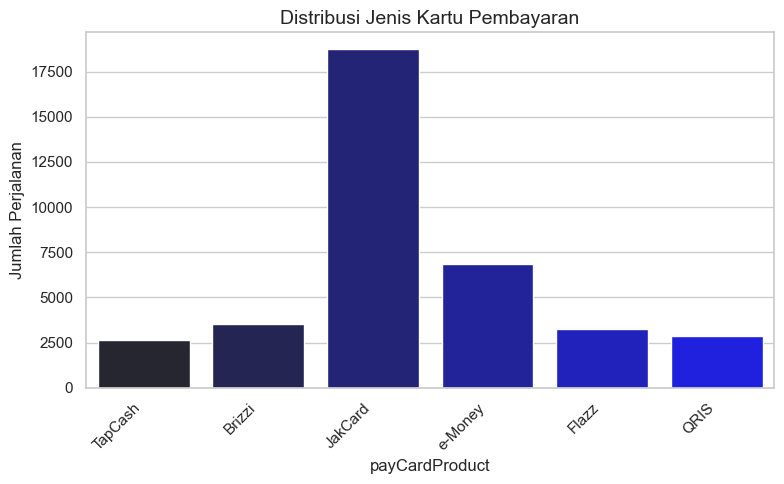


=== Distribusi kategori_usia ===


,Jumlah,Persen (%)
kategori_usia,,
Dewasa,21453,56.60
Pra-Lansia,10253,27.05
Remaja,3882,10.24
Anak-anak,1530,4.04
Lansia,782,2.06


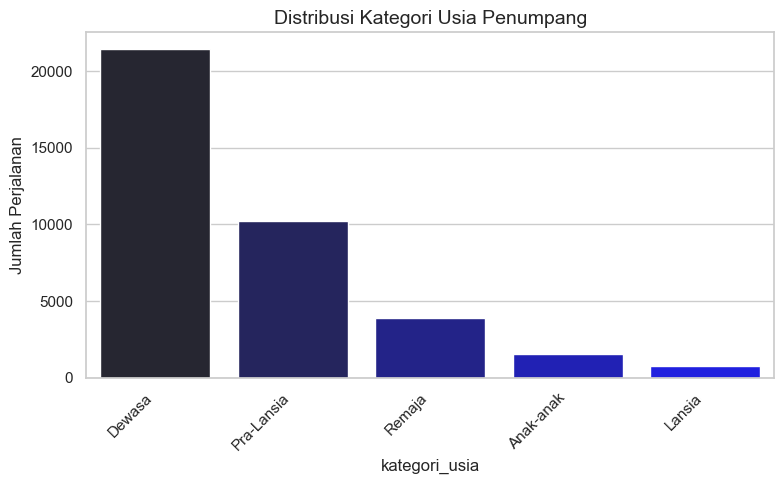


=== Distribusi tapInDay ===


,Jumlah,Persen (%)
tapInDay,,
Jumat,6851,18.08
Rabu,6840,18.05
Senin,6838,18.04
Selasa,6835,18.03
Kamis,6834,18.03
Minggu,1872,4.94
Sabtu,1830,4.83


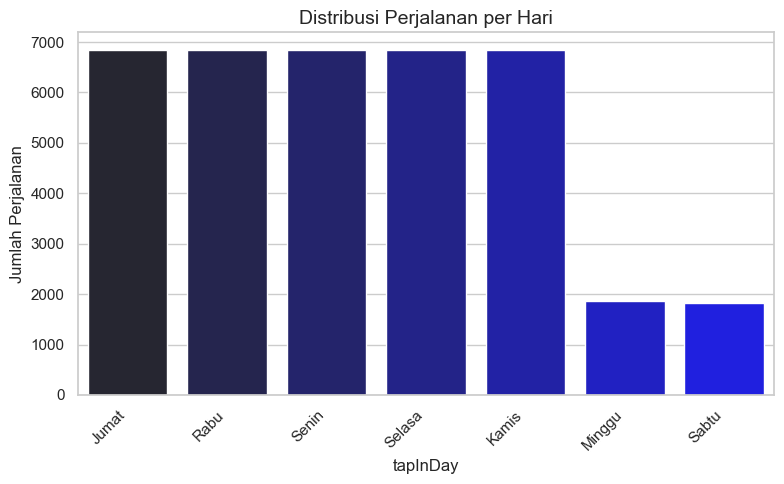


=== Distribusi corridorName ===


,Jumlah,Persen (%)
corridorName,,
Cibubur - Balai Kota,391,11.53
Ciputat - Csw,383,11.30
Pulo Gadung - Monas,343,10.12
Harmoni - Jakarta International Stadium,338,9.97
Kebayoran Lama - Tanah Abang,333,9.82
Kalideres - Bundaran Hi Via Veteran,332,9.79
Kampung Rambutan - Pondok Gede,329,9.71
Rusun Pondok Bambu - Walikota Jakarta Timur,326,9.62
Rusun Rawa Bebek - Kodamar,312,9.20


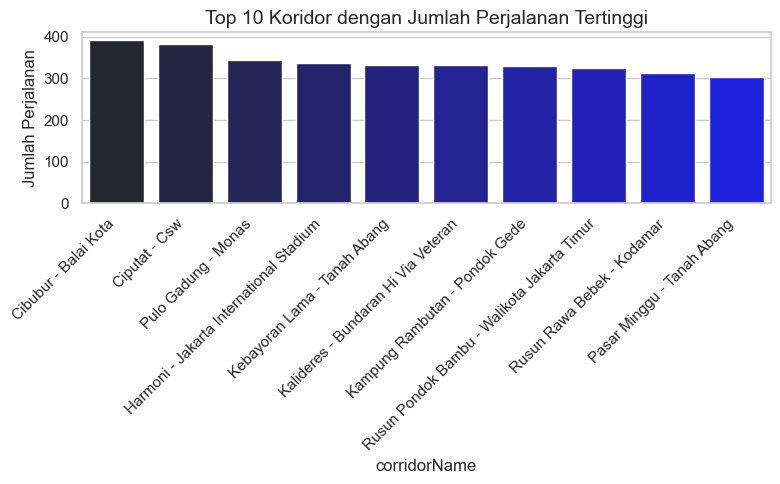

In [35]:
# Fungsi bantu: hitung distribusi (jumlah & persen) dan plot bar chart
def plot_categorical_distribution(df, col, title, top_n=None, exclude_unknown=False):
    # Jika exclude_unknown=True, hapus kategori 'Tidak Diketahui'
    data = df.copy()
    if exclude_unknown:
        data = data[data[col] != 'Tidak Diketahui']

    counts = data[col].value_counts(dropna=False)
    if top_n:
        counts = counts.head(top_n)  # Ambil top N kategori jika ada batasan
    percents = (counts / counts.sum() * 100).round(2)

    # Buat DataFrame ringkasan
    summary = pd.DataFrame({'Jumlah': counts, 'Persen (%)': percents})
    print(f"\n=== Distribusi {col} ===")
    display(summary)

    # Gunakan palet biru tua (gradasi gelap)
    palette = sns.color_palette("dark:blue", n_colors=len(counts))

    # Plot Bar Chart
    plt.figure(figsize=(8, 5))
    sns.barplot(x=counts.index, y=counts.values, palette=palette)
    plt.title(title, fontsize=14)
    plt.xlabel(col)
    plt.ylabel('Jumlah Perjalanan')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Analisis tiap kolom
plot_categorical_distribution(df, 'payCardProduct', 'Distribusi Jenis Kartu Pembayaran')
plot_categorical_distribution(df, 'kategori_usia', 'Distribusi Kategori Usia Penumpang')
plot_categorical_distribution(df, 'tapInDay', 'Distribusi Perjalanan per Hari')

# Top 10 koridor, kecualikan 'Tidak Diketahui'
plot_categorical_distribution(
    df, 
    'corridorName', 
    'Top 10 Koridor dengan Jumlah Perjalanan Tertinggi', 
    top_n=10, 
    exclude_unknown=True
)


In [36]:
from scipy import stats
import numpy as np

# Filter hanya baris dengan durasi valid (bukan NaN)
valid_mask = df['durasi_menit'].notna()
df_valid = df.loc[valid_mask]

# --- Z-score method (threshold 3) ---
z_scores = np.abs(stats.zscore(df_valid['durasi_menit']))
outliers_zscore = df_valid[z_scores > 3]
print(f"Jumlah outlier berdasarkan Z-score (>3): {len(outliers_zscore)}")

# --- IQR method ---
Q1 = df_valid['durasi_menit'].quantile(0.25)
Q3 = df_valid['durasi_menit'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = df_valid[(df_valid['durasi_menit'] < lower_bound) | (df_valid['durasi_menit'] > upper_bound)]
print(f"Jumlah outlier berdasarkan IQR: {len(outliers_iqr)}")


Jumlah outlier berdasarkan Z-score (>3): 49
Jumlah outlier berdasarkan IQR: 39


### **4.1 Question 1**

**Objective 1: Persentase Perjalanan Tidak Tap-Out**
**Tujuan**
Menghitung persentase perjalanan yang tidak memiliki data `tapOutTime` (indikasi insiden *tidak tap-out*) dari keseluruhan transaksi dalam periode analisis.  
Langkah ini penting karena kasus *tidak tap-out* menjadi indikator potensi error perangkat, perilaku pengguna, atau masalah proses validasi transaksi.

Total Transaksi       : 37,900
Jumlah Tidak Tap-Out  : 1,344 (3.55%)
95% CI                : 3.36% – 3.73%
Z-statistic           : -15.30
P-value (one-tailed)  : 0.0000
Keputusan             : Tolak H0 (Proporsi < 5%, signifikan lebih rendah)


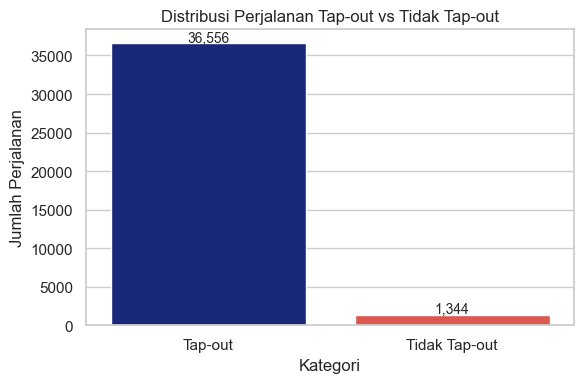

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

# --- Data Dasar ---
total_transaksi = len(df)
no_tapout_count = df['isNoTapOut'].sum()

# --- Z-test untuk Proporsi ---
# Hipotesis: H0: proporsi >= 5%, Ha: proporsi < 5% (uji "smaller")
count = np.array([no_tapout_count])       # jumlah kasus tidak tap-out
nobs = np.array([total_transaksi])        # total sampel

z_stat, p_value = proportions_ztest(count, nobs, value=0.05, alternative='smaller')

# Pastikan hasil jadi scalar
z_stat = float(z_stat)
p_value = float(p_value)

# --- Confidence Interval 95% ---
p_hat = count[0] / nobs[0]
z = 1.96
se = np.sqrt(p_hat * (1 - p_hat) / nobs[0])
ci_lower = p_hat - z * se
ci_upper = p_hat + z * se

# --- Keputusan ---
if p_value <= 0.05:
    keputusan = "Tolak H0 (Proporsi < 5%, signifikan lebih rendah)"
else:
    keputusan = "Gagal menolak H0 (Proporsi tidak terbukti lebih rendah)"

# --- Print Hasil ---
print(f"Total Transaksi       : {total_transaksi:,}")
print(f"Jumlah Tidak Tap-Out  : {no_tapout_count:,} ({p_hat:.2%})")
print(f"95% CI                : {ci_lower:.2%} – {ci_upper:.2%}")
print(f"Z-statistic           : {z_stat:.2f}")
print(f"P-value (one-tailed)  : {p_value:.4f}")
print(f"Keputusan             : {keputusan}")

# --- Visualisasi ---
plt.figure(figsize=(6,4))
sns.barplot(x=['Tap-out', 'Tidak Tap-out'],
            y=[total_transaksi - no_tapout_count, no_tapout_count],
            palette=["#0A1D8A", '#F44336'])
plt.title("Distribusi Perjalanan Tap-out vs Tidak Tap-out")
plt.ylabel("Jumlah Perjalanan")
plt.xlabel("Kategori")
for i, val in enumerate([total_transaksi - no_tapout_count, no_tapout_count]):
    plt.text(i, val + 200, f"{val:,}", ha='center', fontsize=10)
plt.tight_layout()
plt.show()


**Problem 1: Proporsi Perjalanan Tidak Tap-Out**

**Hasil Analisis**
- **Total transaksi:** 37.900 perjalanan  
- **Jumlah tidak tap-out:** 1.344 perjalanan (**3,55%**)  
- **95% Confidence Interval (CI):** 3,36% – 3,73%  

**Uji Hipotesis (Z-test)**
- **H₀:** Proporsi ≥ 5% (setidaknya 5%)  
- **H₁:** Proporsi < 5% (lebih rendah dari 5%)  
- **Z-statistic:** -15,30  
- **p-value (one-tailed):** 0.0000 (**signifikan**)  

**Interpretasi**
Proporsi kasus **tidak tap-out** hanya **3,55%**,  
secara statistik **signifikan lebih rendah** dibanding ambang batas 5%.  
Dengan p-value < 0.05, kita **menolak H₀** dan menyimpulkan bahwa proporsi insiden **terkendali dan tidak berlebihan**.

**Visualisasi**
Bar chart berikut menunjukkan distribusi perjalanan:  
Mayoritas perjalanan berhasil tap-out, hanya sebagian kecil yang gagal.

---

### **4.2 Question 2**

=== Uji Hipotesis Proporsi (Halte Teratas Berdasarkan Jumlah Insiden) ===
Halte Asal           : Bkn
Jumlah Insiden       : 10 dari 173 perjalanan
Proporsi Insiden     : 5.78%
Z-statistic          : 1.59
P-value (one-tailed) : 0.0556
Keputusan            : Gagal menolak H₀ (Proporsi tidak berbeda signifikan)


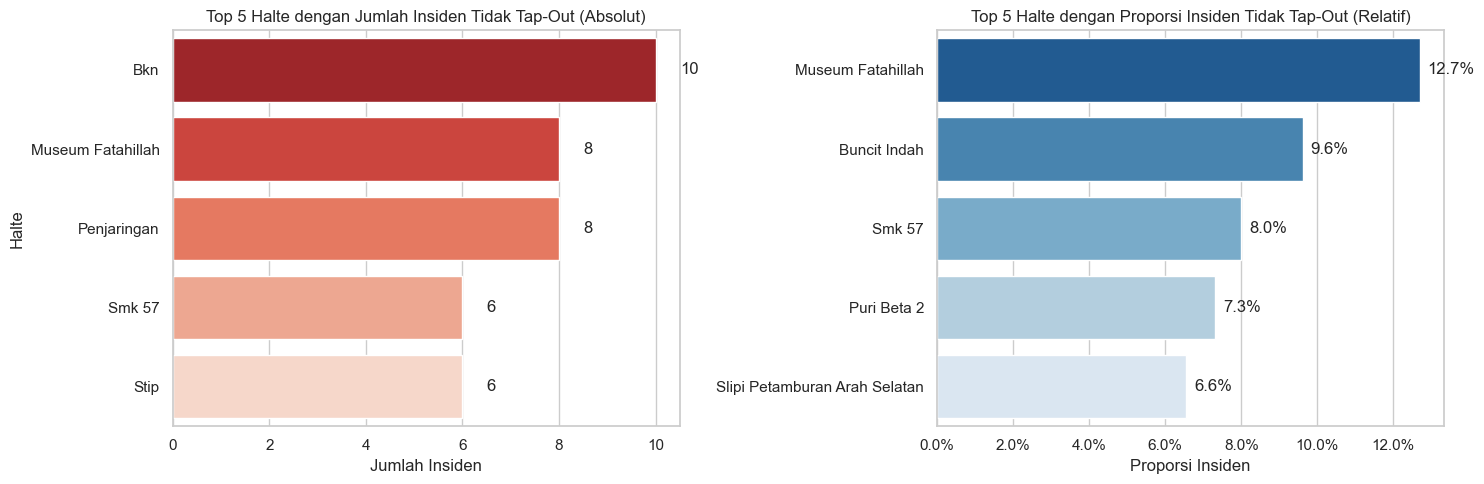

In [38]:
from statsmodels.stats.proportion import proportions_ztest

# --- 1. Buat kolom halte asal ---
df['halte_asal'] = df['tapInStopsName']

# --- 2. Hitung total perjalanan & insiden per halte ---
summary_halte = df.groupby('halte_asal').agg(
    total_perjalanan=('transID', 'count'),
    total_no_tapout=('isNoTapOut', 'sum')
).reset_index()

summary_halte['proporsi_no_tapout'] = summary_halte['total_no_tapout'] / summary_halte['total_perjalanan']

# --- 3. Ambil Top 5 berdasarkan jumlah insiden absolut ---
top5_jumlah = summary_halte.sort_values(by='total_no_tapout', ascending=False).head(5)

# --- 4. Ambil Top 5 berdasarkan proporsi (filter agar perjalanan > 50 biar proporsinya wajar) ---
top5_proporsi = summary_halte[summary_halte['total_perjalanan'] > 50] \
    .sort_values(by='proporsi_no_tapout', ascending=False).head(5)

# --- 5. Uji hipotesis untuk halte teratas berdasarkan jumlah insiden ---
top_halte = top5_jumlah.iloc[0]
count = np.array([top_halte['total_no_tapout'],
                  summary_halte['total_no_tapout'].sum() - top_halte['total_no_tapout']])
nobs = np.array([top_halte['total_perjalanan'],
                 summary_halte['total_perjalanan'].sum() - top_halte['total_perjalanan']])

z_stat, p_val = proportions_ztest(count, nobs, alternative='larger')

print("=== Uji Hipotesis Proporsi (Halte Teratas Berdasarkan Jumlah Insiden) ===")
print(f"Halte Asal           : {top_halte['halte_asal']}")
print(f"Jumlah Insiden       : {int(top_halte['total_no_tapout'])} dari {int(top_halte['total_perjalanan'])} perjalanan")
print(f"Proporsi Insiden     : {top_halte['proporsi_no_tapout']:.2%}")
print(f"Z-statistic          : {z_stat:.2f}")
print(f"P-value (one-tailed) : {p_val:.4f}")

if p_val <= 0.05:
    print("Keputusan            : Tolak H₀ (Proporsi halte ini signifikan lebih tinggi)")
else:
    print("Keputusan            : Gagal menolak H₀ (Proporsi tidak berbeda signifikan)")

# --- 6. Visualisasi dua analisis ---
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Grafik kiri: Top 5 jumlah insiden
sns.barplot(data=top5_jumlah, y='halte_asal', x='total_no_tapout', ax=axes[0], palette='Reds_r')
axes[0].set_title("Top 5 Halte dengan Jumlah Insiden Tidak Tap-Out (Absolut)")
axes[0].set_xlabel("Jumlah Insiden")
axes[0].set_ylabel("Halte")
for i, v in enumerate(top5_jumlah['total_no_tapout']):
    axes[0].text(v + 0.5, i, str(int(v)), va='center')

# Grafik kanan: Top 5 proporsi insiden
sns.barplot(data=top5_proporsi, y='halte_asal', x='proporsi_no_tapout', ax=axes[1], palette='Blues_r')
axes[1].set_title("Top 5 Halte dengan Proporsi Insiden Tidak Tap-Out (Relatif)")
axes[1].set_xlabel("Proporsi Insiden")
axes[1].set_ylabel("")
axes[1].xaxis.set_major_formatter(lambda x, _: f"{x:.1%}")
for i, v in enumerate(top5_proporsi['proporsi_no_tapout']):
    axes[1].text(v + 0.002, i, f"{v:.1%}", va='center')

plt.tight_layout()
plt.show()


**Problem 2: Identifikasi Top 5 Halte Asal dengan Insiden Tidak Tap-Out Tertinggi**

**Hasil Analisis**

Kita melihat insiden tidak tap-out dari dua sudut pandang:

1. **Jumlah insiden absolut (Top 5 berdasarkan jumlah kasus)**
   - Menunjukkan halte dengan volume masalah terbesar.
   - Cocok untuk memprioritaskan halte yang harus segera dievaluasi karena jumlah kasusnya paling banyak.

2. **Proporsi insiden relatif (Top 5 berdasarkan persentase insiden)**
   - Menghilangkan bias halte ramai.
   - Menunjukkan halte mana yang memiliki **risiko tertinggi per penumpang**, meskipun jumlah penumpangnya sedikit.

**Hasil Temuan**
Berdasarkan dataset:

**Top 5 Berdasarkan Jumlah Insiden Absolut**
| Halte Asal           | Jumlah Insiden | Total Perjalanan | Proporsi Insiden |
|----------------------|----------------|------------------|------------------|
| Bkn                  | 10             | 173              | 5.78%            |
| Museum Fatahillah    | 8              | 63               | 12.70%           |
| Penjaringan          | 8              | 243              | 3.29%            |
| Smk 57               | 6              | 75               | 8.00%            |
| Stip                 | 6              | 60               | 10.00%           |

**Top 5 Berdasarkan Proporsi Insiden (Perjalanan >50)**
| Halte Asal                   | Jumlah Insiden | Total Perjalanan | Proporsi Insiden |
|------------------------------|----------------|------------------|------------------|
| Museum Fatahillah            | 8              | 63               | 12.70%           |
| Buncit Indah                 | 5              | 52               | 9.60%            |
| Smk 57                       | 6              | 75               | 8.00%            |
| Puri Beta 2                  | 6              | 82               | 7.30%            |
| Slipi Petamburan Arah Selatan| 5              | 76               | 6.60%            |


**Uji Hipotesis Proporsi (Halte Teratas Berdasarkan Jumlah Insiden)**

- **H₀ (Hipotesis Nol):** Proporsi insiden halte Bkn ≤ rata-rata halte lain (tidak lebih tinggi signifikan).  
- **H₁ (Hipotesis Alternatif):** Proporsi insiden halte Bkn lebih tinggi signifikan dibanding halte lain.

**Hasil Uji:**
- **Halte Asal:** Bkn  
- **Jumlah Insiden:** 10 dari 173 perjalanan (5.78%)  
- **Z-statistic:** 1.59  
- **P-value (one-tailed):** 0.0556  
- **Keputusan:** Gagal menolak H₀ (tidak ada bukti signifikan bahwa halte Bkn memiliki proporsi insiden lebih tinggi dari rata-rata halte lain pada tingkat signifikansi 5%).

**Visualisasi**
Grafik berikut menggambarkan **dua perspektif berbeda**:

- **Kiri:** Halte dengan jumlah insiden tidak tap-out terbanyak (absolut).
- **Kanan:** Halte dengan proporsi insiden tertinggi (relatif terhadap total perjalanan).


**Relevansi Analisis**
- Analisis ini tetap **relevan** meskipun hanya berbasis **halte asal (tap-in)** karena:
  - Memberikan indikasi awal halte mana yang **berpotensi memicu masalah tap-out**.
  - Dapat menjadi prioritas pengawasan teknis atau edukasi penumpang.
  - Memberi dasar bagi tim operasional untuk **investigasi lebih lanjut**.


**Keterbatasan**
- **Tidak dapat menentukan halte tujuan (tap-out) di mana error terjadi** karena data insiden hanya tercatat di sisi tap-in.
- Hasil bersifat **indikasi, bukan bukti lokasi error**:
  - Insiden bisa disebabkan oleh sistem halte tujuan,
  - Perilaku penumpang (lupa tap-out),
  - Faktor rute atau koridor tertentu.


**Kesimpulan**
- **Bkn** memiliki jumlah insiden tertinggi (10 kasus), tetapi proporsinya **tidak signifikan lebih tinggi** dari rata-rata halte lain.
- Beberapa halte dengan **proporsi tinggi** (seperti Museum Fatahillah) bisa menjadi **prioritas audit**.
- Analisis lebih lanjut dengan **data tambahan (log tap-out atau error sistem)** dibutuhkan agar penyebab pasti dapat diidentifikasi.

---

### **4.3 Question 3**

**Problem 3: Analisis Insiden Tidak Tap-Out Berdasarkan Segmen Pelanggan**

Analisis ini dilakukan untuk melihat apakah **proporsi insiden tidak tap-out** berbeda signifikan berdasarkan:
1. **Kategori Usia Penumpang**  
2. **Jenis Kartu Pembayaran**  

**A. Analisis Berdasarkan Usia**

**Langkah Analisis**
1. Gunakan kolom `kategori_usia` (Anak-anak, Remaja, Dewasa, Pra-Lansia, Lansia).
2. Hitung:
   - **Total perjalanan** per kategori.
   - **Jumlah insiden tidak tap-out** per kategori.
   - **Proporsi insiden** (persentase insiden per kategori).
3. **Visualisasi**:
   - Bar chart jumlah insiden per kategori.
   - Bar chart proporsi insiden per kategori.
4. **Uji Hipotesis (Chi-Square)**:
   - **H₀:** Tidak ada perbedaan proporsi insiden antar kelompok usia.  
   - **H₁:** Ada perbedaan proporsi insiden antar kelompok usia.
   - Jika p-value ≤ 0.05 → Tolak H₀ (ada perbedaan signifikan).

**Output yang Ditampilkan**
- **Tabel Ringkasan** (total perjalanan, jumlah insiden, proporsi).
- **2 grafik (jumlah & proporsi)**.
- **Hasil Chi-Square test (p-value, keputusan)**.
- **Interpretasi hasil** (kelompok usia mana yang paling berisiko).

**B. Analisis Berdasarkan Jenis Kartu Pembayaran**

**Langkah Analisis**
1. Gunakan kolom `payCardProduct` (jenis kartu: TapCash, Brizzi, JakCard, e-Money, Flazz, QRIS).
2. Hitung:
   - **Total perjalanan** per jenis kartu.
   - **Jumlah insiden tidak tap-out** per jenis kartu.
   - **Proporsi insiden**.
3. **Visualisasi**:
   - Bar chart jumlah insiden per jenis kartu.
   - Bar chart proporsi insiden per jenis kartu.
4. **Uji Hipotesis (Chi-Square)**:
   - **H₀:** Tidak ada perbedaan proporsi insiden antar jenis kartu.
   - **H₁:** Ada perbedaan proporsi insiden antar jenis kartu.
   - Jika p-value ≤ 0.05 → Tolak H₀ (ada perbedaan signifikan).

**Output yang Ditampilkan**
- **Tabel Ringkasan** (total perjalanan, jumlah insiden, proporsi).
- **2 grafik (jumlah & proporsi)**.
- **Hasil Chi-Square test (p-value, keputusan)**.
- **Interpretasi hasil** (jenis kartu mana yang paling bermasalah).

**Catatan Analisis**
- Chi-Square dipilih karena:
  - Data berbentuk **kategori** (usia, jenis kartu).
  - Kita ingin membandingkan **proporsi antar kategori**.
  - Tidak perlu asumsi distribusi normal (non-parametrik).
- Jika ditemukan perbedaan signifikan, kita bisa **lanjut dengan uji proporsi berpasangan** (post-hoc) untuk tahu kategori mana yang berbeda signifikan.

**Kesimpulan yang Akan Disajikan**
- Kelompok usia mana yang memiliki **risiko insiden tertinggi (proporsi)**.
- Jenis kartu mana yang paling banyak/besar proporsi insiden.
- Apakah perbedaan ini **signifikan secara statistik** (Chi-Square).



=== Uji Hipotesis Berdasarkan Kategori Usia ===
Chi-Square (jumlah absolut insiden): Chi2=5.02, p-value=0.2857
Z-test Proporsi (kelompok tertinggi - Lansia): Z=1.62, p-value=0.0531

=== Uji Hipotesis Berdasarkan Jenis Kartu ===
Chi-Square (jumlah absolut insiden): Chi2=8.01, p-value=0.1555
Z-test Proporsi (kelompok tertinggi - Flazz): Z=1.32, p-value=0.0928



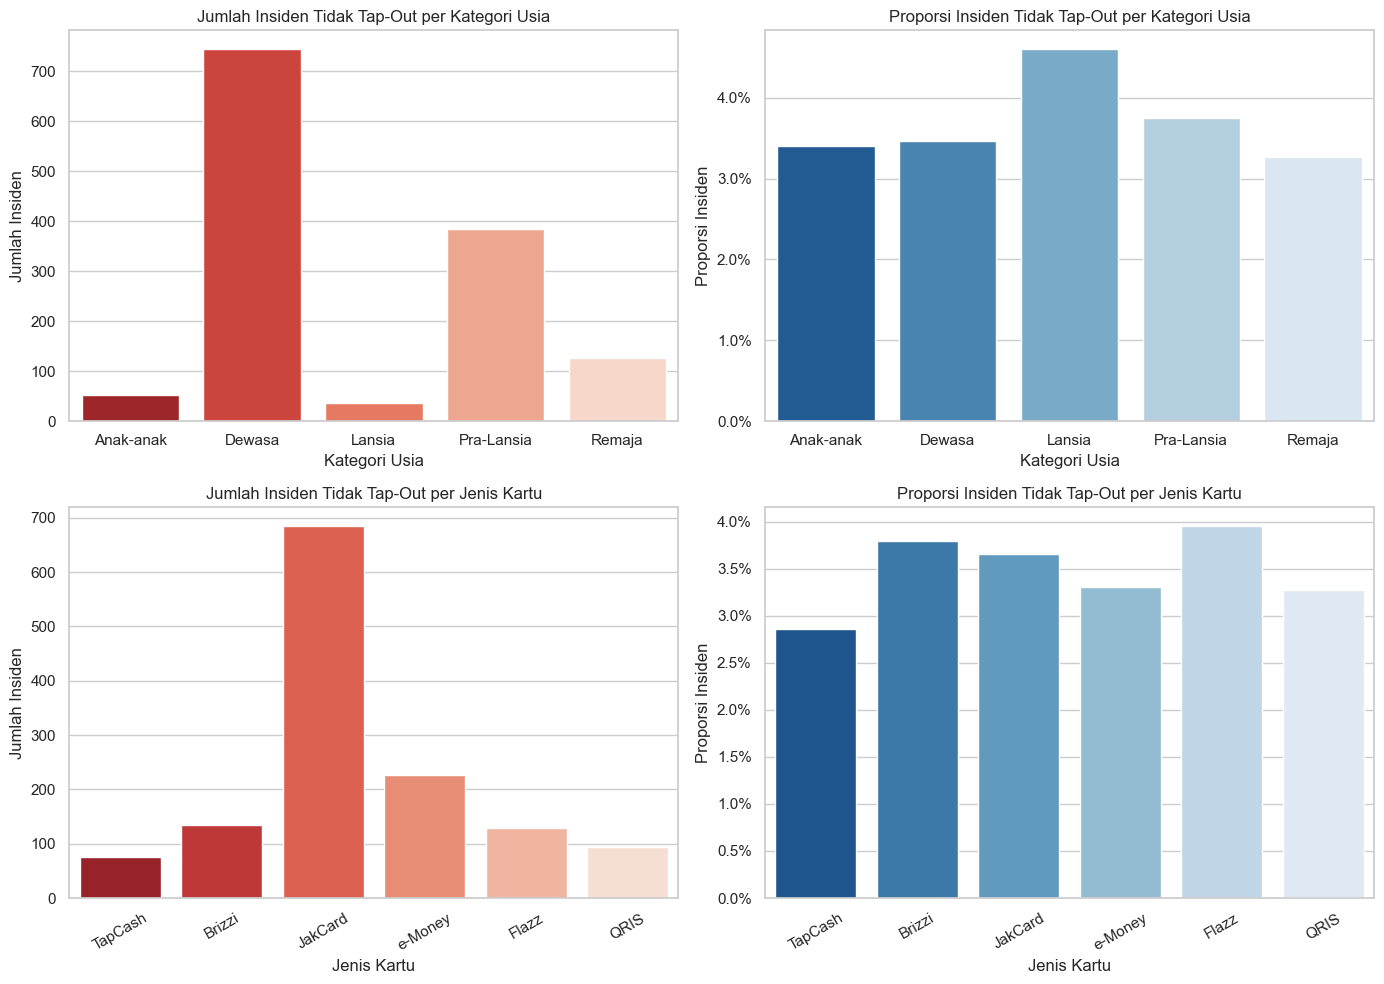


--- Ringkasan Kategori Usia ---
  kategori_usia  total_perjalanan  total_no_tapout  proporsi_no_tapout
0     Anak-anak              1530               52            0.033987
1        Dewasa             21453              744            0.034680
2        Lansia               782               36            0.046036
3    Pra-Lansia             10253              385            0.037550
4        Remaja              3882              127            0.032715

--- Ringkasan Jenis Kartu ---
  payCardProduct  total_perjalanan  total_no_tapout  proporsi_no_tapout
0        TapCash              2657               76            0.028604
1         Brizzi              3531              134            0.037950
2        JakCard             18743              685            0.036547
3        e-Money              6866              227            0.033061
4          Flazz              3234              128            0.039579
5           QRIS              2869               94            0.032764


In [39]:
from scipy.stats import chi2_contingency, chisquare
from statsmodels.stats.proportion import proportions_ztest

# --- A. Analisis Berdasarkan Kategori Usia ---
summary_usia = df.groupby('kategori_usia').agg(
    total_perjalanan=('transID', 'count'),
    total_no_tapout=('isNoTapOut', 'sum')
).reset_index()
summary_usia['proporsi_no_tapout'] = summary_usia['total_no_tapout'] / summary_usia['total_perjalanan']

# --- 1) Uji Chi-Square Goodness of Fit (jumlah absolut insiden) ---
observed_usia = summary_usia['total_no_tapout'].values
# Ekspektasi proporsional berdasarkan total perjalanan (agar fair)
expected_usia = (summary_usia['total_perjalanan'] / summary_usia['total_perjalanan'].sum()) * observed_usia.sum()
chi2_abs_usia, p_abs_usia = chisquare(f_obs=observed_usia, f_exp=expected_usia)

# --- 2) Z-test Proporsi (rate insiden untuk kelompok dengan proporsi tertinggi) ---
top_usia = summary_usia.loc[summary_usia['proporsi_no_tapout'].idxmax()]
count_usia = np.array([
    top_usia['total_no_tapout'],
    summary_usia['total_no_tapout'].sum() - top_usia['total_no_tapout']
])
nobs_usia = np.array([
    top_usia['total_perjalanan'],
    summary_usia['total_perjalanan'].sum() - top_usia['total_perjalanan']
])
z_usia, pval_usia = proportions_ztest(count_usia, nobs_usia, alternative='larger')


# --- B. Analisis Berdasarkan Jenis Kartu ---
summary_kartu = df.groupby('payCardProduct').agg(
    total_perjalanan=('transID', 'count'),
    total_no_tapout=('isNoTapOut', 'sum')
).reset_index()
summary_kartu['proporsi_no_tapout'] = summary_kartu['total_no_tapout'] / summary_kartu['total_perjalanan']

# --- 1) Uji Chi-Square Goodness of Fit (jumlah absolut insiden) ---
observed_kartu = summary_kartu['total_no_tapout'].values
expected_kartu = (summary_kartu['total_perjalanan'] / summary_kartu['total_perjalanan'].sum()) * observed_kartu.sum()
chi2_abs_kartu, p_abs_kartu = chisquare(f_obs=observed_kartu, f_exp=expected_kartu)

# --- 2) Z-test Proporsi (rate insiden untuk kelompok dengan proporsi tertinggi) ---
top_kartu = summary_kartu.loc[summary_kartu['proporsi_no_tapout'].idxmax()]
count_kartu = np.array([
    top_kartu['total_no_tapout'],
    summary_kartu['total_no_tapout'].sum() - top_kartu['total_no_tapout']
])
nobs_kartu = np.array([
    top_kartu['total_perjalanan'],
    summary_kartu['total_perjalanan'].sum() - top_kartu['total_perjalanan']
])
z_kartu, pval_kartu = proportions_ztest(count_kartu, nobs_kartu, alternative='larger')


# --- Cetak Hasil ---
print("=== Uji Hipotesis Berdasarkan Kategori Usia ===")
print(f"Chi-Square (jumlah absolut insiden): Chi2={chi2_abs_usia:.2f}, p-value={p_abs_usia:.4f}")
print(f"Z-test Proporsi (kelompok tertinggi - {top_usia['kategori_usia']}): Z={z_usia:.2f}, p-value={pval_usia:.4f}")
print()

print("=== Uji Hipotesis Berdasarkan Jenis Kartu ===")
print(f"Chi-Square (jumlah absolut insiden): Chi2={chi2_abs_kartu:.2f}, p-value={p_abs_kartu:.4f}")
print(f"Z-test Proporsi (kelompok tertinggi - {top_kartu['payCardProduct']}): Z={z_kartu:.2f}, p-value={pval_kartu:.4f}")
print()

# --- Visualisasi (Jumlah vs Proporsi) ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Usia - Jumlah
sns.barplot(data=summary_usia, x='kategori_usia', y='total_no_tapout', ax=axes[0,0], palette='Reds_r')
axes[0,0].set_title("Jumlah Insiden Tidak Tap-Out per Kategori Usia")
axes[0,0].set_xlabel("Kategori Usia")
axes[0,0].set_ylabel("Jumlah Insiden")

# Usia - Proporsi
sns.barplot(data=summary_usia, x='kategori_usia', y='proporsi_no_tapout', ax=axes[0,1], palette='Blues_r')
axes[0,1].set_title("Proporsi Insiden Tidak Tap-Out per Kategori Usia")
axes[0,1].set_xlabel("Kategori Usia")
axes[0,1].set_ylabel("Proporsi Insiden")
axes[0,1].yaxis.set_major_formatter(lambda x, _: f"{x:.1%}")

# Kartu - Jumlah
sns.barplot(data=summary_kartu, x='payCardProduct', y='total_no_tapout', ax=axes[1,0], palette='Reds_r')
axes[1,0].set_title("Jumlah Insiden Tidak Tap-Out per Jenis Kartu")
axes[1,0].set_xlabel("Jenis Kartu")
axes[1,0].set_ylabel("Jumlah Insiden")
axes[1,0].tick_params(axis='x', rotation=30)

# Kartu - Proporsi
sns.barplot(data=summary_kartu, x='payCardProduct', y='proporsi_no_tapout', ax=axes[1,1], palette='Blues_r')
axes[1,1].set_title("Proporsi Insiden Tidak Tap-Out per Jenis Kartu")
axes[1,1].set_xlabel("Jenis Kartu")
axes[1,1].set_ylabel("Proporsi Insiden")
axes[1,1].yaxis.set_major_formatter(lambda x, _: f"{x:.1%}")
axes[1,1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

# --- Ringkasan ---
print("\n--- Ringkasan Kategori Usia ---")
print(summary_usia[['kategori_usia','total_perjalanan','total_no_tapout','proporsi_no_tapout']])

print("\n--- Ringkasan Jenis Kartu ---")
print(summary_kartu[['payCardProduct','total_perjalanan','total_no_tapout','proporsi_no_tapout']])


**Problem 3: Distribusi Insiden Tidak Tap-Out Berdasarkan Segmen Pelanggan**

**Tujuan**
Menganalisis apakah insiden **tidak tap-out** berbeda signifikan berdasarkan:
1. **Kategori Usia** (*Anak-anak, Remaja, Dewasa, Pra-Lansia, Lansia*), dan  
2. **Jenis Kartu Pembayaran** (*TapCash, Brizzi, JakCard, e-Money, Flazz, QRIS*).

Dua pendekatan uji hipotesis digunakan:
- **Chi-Square Goodness of Fit** → untuk menguji apakah distribusi **jumlah absolut insiden** sejalan dengan distribusi perjalanan.
- **Z-test Proporsi** → untuk menguji apakah kelompok dengan **proporsi insiden tertinggi** secara signifikan lebih tinggi dari kelompok lain.

**Hasil Ringkasan Data**

**Kategori Usia**
| Kategori Usia | Total Perjalanan | Jumlah Tidak Tap-Out | Proporsi Tidak Tap-Out |
|---------------|------------------|-----------------------|--------------------------|
| Anak-anak     | 1.530            | 52                    | 3,40%                   |
| Remaja        | 3.882            | 127                   | 3,27%                   |
| Dewasa        | 21.453           | **744 (terbanyak)**   | 3,47%                   |
| Pra-Lansia    | 10.253           | 385                   | 3,76%                   |
| Lansia        | 782              | 36                    | **4,60% (proporsi tertinggi)**    |

**Jenis Kartu**
| Jenis Kartu   | Total Perjalanan | Jumlah Tidak Tap-Out | Proporsi Tidak Tap-Out |
|---------------|------------------|-----------------------|--------------------------|
| TapCash       | 2.657            | 76                    | 2,86%                   |
| Brizzi        | 3.531            | 134                   | 3,80%                   |
| JakCard       | 18.743           | **685 (terbanyak)**   | 3,65%                   |
| e-Money       | 6.866            | 227                   | 3,31%                   |
| Flazz         | 3.234            | 128                   | **3,96% (proporsi tertinggi)**    |
| QRIS          | 2.869            | 94                    | 3,28%                   |


**Hasil Uji Hipotesis**

**1. Berdasarkan Kategori Usia**
- **Chi-Square (jumlah absolut insiden):**  
  Chi² = 5,02, p-value = 0,286 (**Gagal menolak H₀**)  
  → Jumlah insiden (744 dari Dewasa, 385 Pra-Lansia, 127 Remaja, dll.) **proporsional dengan total perjalanan**. Tidak ada kelompok usia yang mendominasi secara absolut.
- **Z-test Proporsi (kelompok tertinggi: Lansia):**  
  Z = 1,62, p-value = 0,053 (**Tidak signifikan, borderline**)  
  → Lansia memiliki **proporsi insiden tertinggi (4,60%)**, namun perbedaan dengan kelompok lain belum signifikan secara statistik.

**2. Berdasarkan Jenis Kartu**
- **Chi-Square (jumlah absolut insiden):**  
  Chi² = 8,01, p-value = 0,156 (**Gagal menolak H₀**)  
  → Jumlah insiden (terbanyak pada JakCard: 685) **sesuai dengan volume perjalanan**. Tidak ada jenis kartu yang secara absolut mendominasi.
- **Z-test Proporsi (kelompok tertinggi: Flazz):**  
  Z = 1,32, p-value = 0,093 (**Tidak signifikan**)  
  → Flazz memiliki **proporsi insiden tertinggi (3,96%)**, tetapi perbedaan tidak signifikan dibanding kelompok lain.


**Interpretasi**
1. **Secara absolut**, mayoritas insiden berasal dari **Dewasa** (744 kasus) dan pengguna **JakCard** (685 kasus). Namun, jumlah ini **sejalan dengan banyaknya perjalanan** dari kelompok tersebut, sehingga **tidak menunjukkan dominasi yang tidak wajar**.
2. **Secara proporsi**, **Lansia (4,60%)** dan **Flazz (3,96%)** menunjukkan tingkat insiden lebih tinggi dibanding kelompok lain, tetapi **perbedaan belum signifikan secara statistik**.
3. Tidak ditemukan perbedaan signifikan baik dalam **jumlah absolut** maupun **proporsi** antar kelompok. Pola ini cenderung dipengaruhi oleh distribusi perjalanan, bukan faktor usia atau jenis kartu secara langsung.
4. **Rekomendasi:** Lakukan analisis lanjutan dengan mempertimbangkan variabel tambahan (koridor, waktu, halte tertentu) untuk mencari penyebab tren pada Lansia dan Flazz.


**Visualisasi**
Empat grafik berikut menggambarkan:
1. **Jumlah absolut** insiden per kategori usia  
2. **Proporsi** insiden per kategori usia  
3. **Jumlah absolut** insiden per jenis kartu  
4. **Proporsi** insiden per jenis kartu  

Hasil visualisasi menunjukkan pola serupa: **jumlah terbesar pada Dewasa dan JakCard**, tetapi **proporsi tertinggi pada Lansia dan Flazz**, keduanya **tidak signifikan secara statistik**.

---

### **4.4 Question 4**

**Problem 4: Perbedaan Insiden Tidak Tap-Out Berdasarkan Jenis Layanan Bus**

**Tujuan**
Menilai apakah insiden **tidak tap-out** memiliki perbedaan signifikan berdasarkan jenis layanan:
- **Reguler**  
- **Royaltrans**  
- **Mikrotrans**

**Langkah Analisis**
1. Hitung:
   - **Total perjalanan** per jenis layanan
   - **Jumlah insiden tidak tap-out**
   - **Proporsi insiden** (persentase)
2. Lakukan dua uji hipotesis:
   - **Chi-Square** → untuk distribusi **jumlah absolut insiden** (apakah proporsional terhadap volume perjalanan).
   - **Z-test proporsi** → untuk menguji apakah kelompok dengan proporsi insiden tertinggi signifikan lebih tinggi dibanding lainnya.
3. Visualisasi:
   - Bar chart jumlah absolut insiden per layanan.
   - Bar chart proporsi insiden per layanan.

**Hasil yang Akan Dilaporkan**
- Ringkasan tabel (total perjalanan, insiden, proporsi).
- Hasil uji statistik (Chi-Square & Z-test).
- Interpretasi:
  - Apakah ada jenis layanan yang memiliki **jumlah absolut insiden** tidak wajar?
  - Apakah ada jenis layanan yang memiliki **proporsi insiden** signifikan lebih tinggi?
- Rekomendasi tindak lanjut (jika ada layanan yang berisiko lebih tinggi).


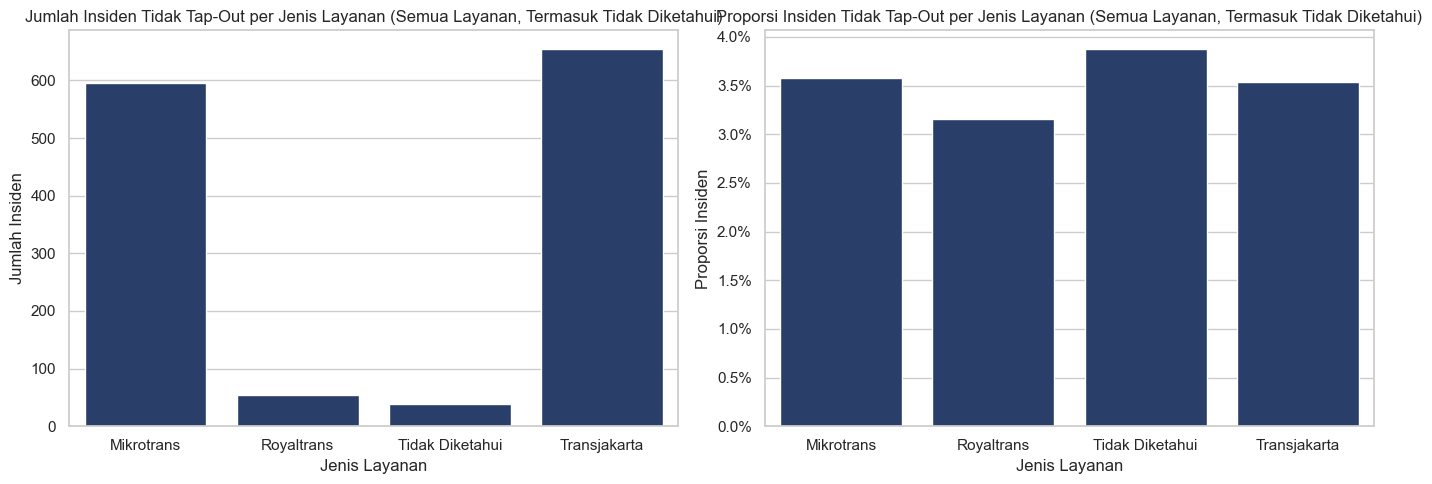

=== Uji Hipotesis Jenis Layanan (Semua Layanan, Termasuk Tidak Diketahui) ===
Chi-Square (jumlah absolut): Chi2=1.15, p-value=0.7656
Z-test Proporsi (kelompok tertinggi - Tidak Diketahui): Z=0.57, p-value=0.2850


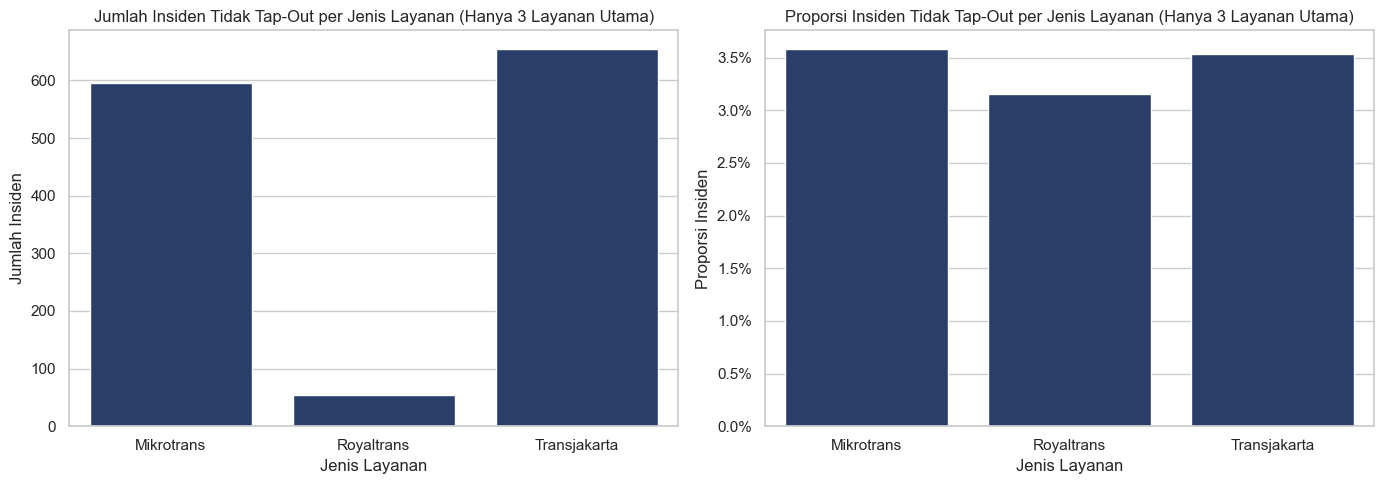

=== Uji Hipotesis Jenis Layanan (Hanya 3 Layanan Utama) ===
Chi-Square (jumlah absolut): Chi2=0.83, p-value=0.6614
Z-test Proporsi (kelompok tertinggi - Mikrotrans): Z=0.40, p-value=0.3434


In [40]:
# --- Data ringkasan layanan ---
summary_layanan = df.groupby('serviceType').agg(
    total_perjalanan=('transID', 'count'),
    total_no_tapout=('isNoTapOut', 'sum')
).reset_index()

summary_layanan['proporsi_no_tapout'] = summary_layanan['total_no_tapout'] / summary_layanan['total_perjalanan']

# Versi 1: Semua layanan (termasuk Tidak Diketahui)
summary_all = summary_layanan.copy()

# Versi 2: Hanya 3 layanan utama
summary_main = summary_layanan[summary_layanan['serviceType'].isin(['Mikrotrans', 'Royaltrans', 'Transjakarta'])].copy()

def analisis_layanan(data, judul="(Semua Layanan)"):
    # --- Chi-square berdasarkan jumlah absolut ---
    chi2, p_chi, _, _ = chi2_contingency([data['total_no_tapout'], data['total_perjalanan'] - data['total_no_tapout']])

    # --- Z-test proporsi: bandingkan layanan dengan proporsi tertinggi ---
    top_service = data.loc[data['proporsi_no_tapout'].idxmax()]
    count = np.array([top_service['total_no_tapout'], data['total_no_tapout'].sum() - top_service['total_no_tapout']])
    nobs = np.array([top_service['total_perjalanan'], data['total_perjalanan'].sum() - top_service['total_perjalanan']])
    z_stat, p_val = proportions_ztest(count, nobs, alternative='larger')

    # --- Visualisasi ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    palette = ['#1f3b73'] * len(data)

    sns.barplot(data=data, x='serviceType', y='total_no_tapout', ax=axes[0], palette=palette)
    axes[0].set_title(f"Jumlah Insiden Tidak Tap-Out per Jenis Layanan {judul}")
    axes[0].set_ylabel("Jumlah Insiden")
    axes[0].set_xlabel("Jenis Layanan")

    sns.barplot(data=data, x='serviceType', y='proporsi_no_tapout', ax=axes[1], palette=palette)
    axes[1].set_title(f"Proporsi Insiden Tidak Tap-Out per Jenis Layanan {judul}")
    axes[1].set_ylabel("Proporsi Insiden")
    axes[1].set_xlabel("Jenis Layanan")
    axes[1].yaxis.set_major_formatter(lambda x, _: f"{x:.1%}")

    plt.tight_layout()
    plt.show()

    print(f"=== Uji Hipotesis Jenis Layanan {judul} ===")
    print(f"Chi-Square (jumlah absolut): Chi2={chi2:.2f}, p-value={p_chi:.4f}")
    print(f"Z-test Proporsi (kelompok tertinggi - {top_service['serviceType']}): Z={z_stat:.2f}, p-value={p_val:.4f}")

# Jalankan analisis untuk dua versi
analisis_layanan(summary_all, "(Semua Layanan, Termasuk Tidak Diketahui)")
analisis_layanan(summary_main, "(Hanya 3 Layanan Utama)")


**Problem 4: Analisis Perbedaan Insiden Berdasarkan Jenis Layanan Bus**

**Hasil Uji Statistik**

**1. Semua Layanan (termasuk "Tidak Diketahui")**
- **Chi-Square (jumlah absolut):** Chi² = 1,15, p-value = 0,7656  
- **Z-test Proporsi (kelompok tertinggi - Tidak Diketahui):** Z = 0,57, p-value = 0,2850  

**2. Hanya 3 Layanan Utama (Mikrotrans, Royaltrans, Transjakarta)**
- **Chi-Square (jumlah absolut):** Chi² = 0,83, p-value = 0,6614  
- **Z-test Proporsi (kelompok tertinggi - Mikrotrans):** Z = 0,40, p-value = 0,3434  

**Interpretasi**
1. **Tidak ada perbedaan signifikan** baik dari sisi **jumlah absolut** maupun **proporsi insiden** antar jenis layanan bus (p-value > 0,05 di semua uji).
2. Kategori **"Tidak Diketahui"** muncul dengan **proporsi insiden tertinggi (3,9%)**, namun hasil uji menunjukkan **tidak signifikan** dibanding layanan lain.  
   - Hal ini cenderung **mengindikasikan masalah data** (misalnya pencatatan rute/layanan yang hilang) ketimbang masalah operasional.
3. **Mikrotrans dan Transjakarta** terlihat memiliki **jumlah insiden absolut jauh lebih banyak** dibanding Royaltrans.  
   - Namun, **volume perjalanan mereka juga jauh lebih besar**, sehingga ketika dihitung sebagai **proporsi (persentase)**, nilainya **relatif sama (3,5–3,6%)**.  
   - **Chi-Square dan Z-test menggunakan proporsi relatif terhadap total perjalanan**, sehingga hasil akhirnya tidak signifikan.
4. **Kesimpulan:** Data menunjukkan bahwa **jenis layanan bus bukan faktor utama** yang menentukan tingginya kasus *tidak tap-out*.  
   Perbedaan jumlah absolut lebih disebabkan **perbedaan volume perjalanan**, bukan karena layanan tertentu lebih “bermasalah”.

**Mengapa P-value Tinggi (Tidak Signifikan)?**
- **Chi-Square dan Z-test** mengukur apakah perbedaan insiden **secara proporsional** berbeda secara statistik, **bukan hanya dari jumlah absolut**.  
- Mikrotrans dan Transjakarta memang punya insiden lebih banyak, tetapi mereka juga punya **volume perjalanan terbesar**, sehingga **rasio insiden relatif sama dengan Royaltrans**.  
- Karena perbedaan ini **tidak cukup besar secara persentase**, hasil uji menyatakan **tidak signifikan** meskipun angka absolutnya terlihat berbeda.

**Visualisasi**
Grafik berikut memisahkan antara:
- **Jumlah absolut insiden** (dipengaruhi volume perjalanan).
- **Proporsi insiden** (menghilangkan pengaruh volume).

Hasilnya menunjukkan **proporsi yang hampir sama antar layanan**, sehingga **jenis layanan tidak menjadi indikator kuat untuk insiden tidak tap-out**.

---


### **4.5 Question 5**


=== Uji Hipotesis Koridor Semua Koridor (Termasuk Tidak Diketahui) ===
Chi-Square (jumlah absolut): Chi2=231.17, p-value=0.2280
Z-test Proporsi (koridor tertinggi - Tidak Diketahui): Z=0.95, p-value=0.1698

--- Ringkasan Top 3 Koridor ---
                     corridorName  total_perjalanan  total_no_tapout  proporsi_no_tapout
213               Tidak Diketahui              1930               76            0.039378
77   Kebayoran Lama - Tanah Abang               333               18            0.054054
30            Cilincing - Rorotan               272               18            0.066176


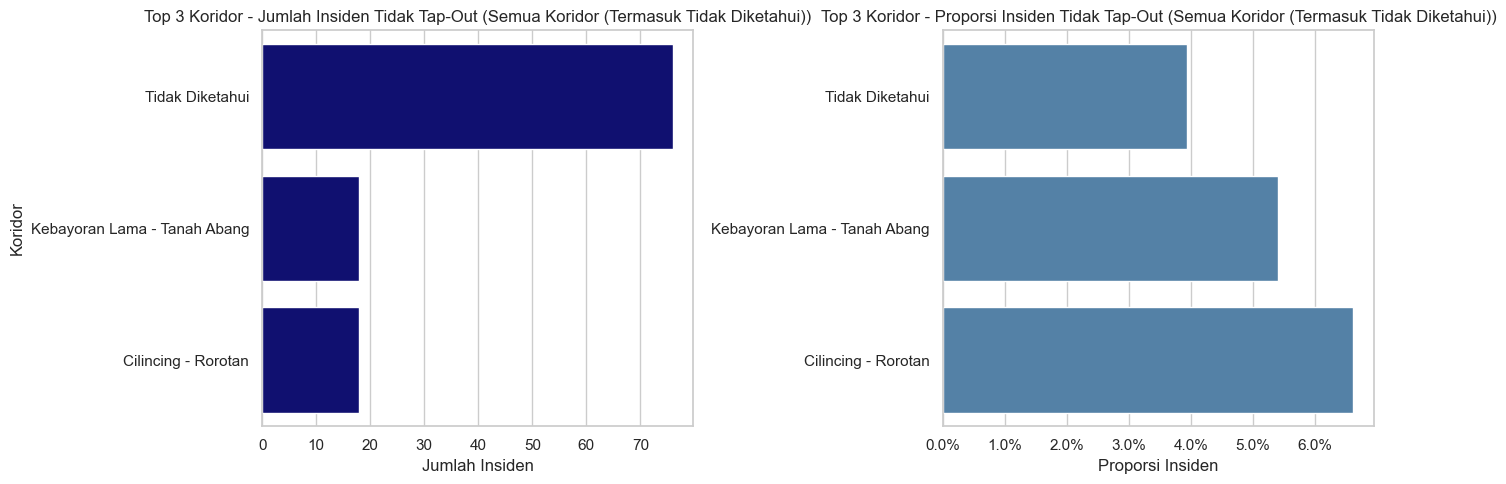


=== Uji Hipotesis Koridor Hanya Koridor Jelas ===
Chi-Square (jumlah absolut): Chi2=231.58, p-value=0.2085
Z-test Proporsi (koridor tertinggi - Kebayoran Lama - Tanah Abang): Z=1.87, p-value=0.0308

--- Ringkasan Top 3 Koridor ---
                    corridorName  total_perjalanan  total_no_tapout  proporsi_no_tapout
77  Kebayoran Lama - Tanah Abang               333               18            0.054054
30           Cilincing - Rorotan               272               18            0.066176
20          Cibubur - Balai Kota               391               16            0.040921


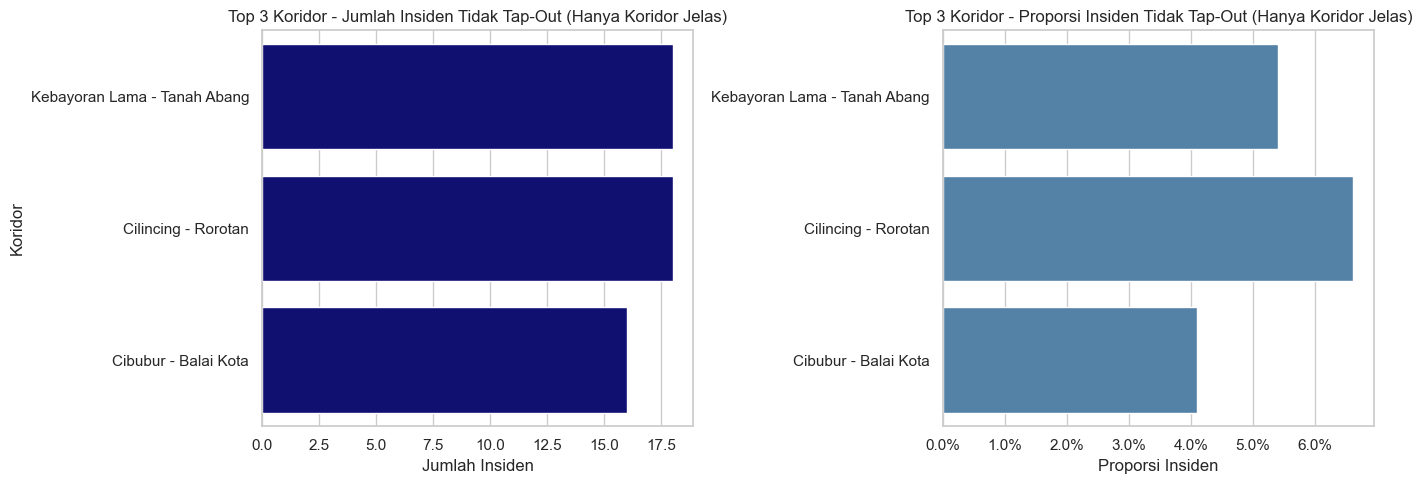

In [41]:
# --- 1. Hitung ringkasan per koridor ---
summary_koridor = df.groupby('corridorName').agg(
    total_perjalanan=('transID', 'count'),
    total_no_tapout=('isNoTapOut', 'sum')
).reset_index()

summary_koridor['proporsi_no_tapout'] = summary_koridor['total_no_tapout'] / summary_koridor['total_perjalanan']

# --- 2. Buat dua versi data ---
# Versi A: semua koridor
summary_all = summary_koridor.copy()

# Versi B: hapus koridor tidak diketahui
summary_clean = summary_koridor[summary_koridor['corridorName'] != 'Tidak Diketahui'].copy()

def analyze_koridor(summary, title_suffix):
    # Ambil Top 3 koridor dengan jumlah insiden terbanyak
    top3 = summary.sort_values(by='total_no_tapout', ascending=False).head(3)

    # --- Chi-Square (jumlah absolut) ---
    obs = summary[['total_no_tapout', 'total_perjalanan']].copy()
    obs['lainnya'] = obs['total_perjalanan'] - obs['total_no_tapout']
    chi2_stat, chi2_p, _, _ = stats.chi2_contingency(obs[['total_no_tapout', 'lainnya']])

    # --- Z-test proporsi: koridor proporsi tertinggi vs lainnya ---
    top_corr = top3.iloc[0]
    count = np.array([top_corr['total_no_tapout'],
                      summary['total_no_tapout'].sum() - top_corr['total_no_tapout']])
    nobs = np.array([top_corr['total_perjalanan'],
                     summary['total_perjalanan'].sum() - top_corr['total_perjalanan']])
    z_stat, z_p = proportions_ztest(count, nobs, alternative='larger')

    # --- Cetak hasil ---
    print(f"\n=== Uji Hipotesis Koridor {title_suffix} ===")
    print(f"Chi-Square (jumlah absolut): Chi2={chi2_stat:.2f}, p-value={chi2_p:.4f}")
    print(f"Z-test Proporsi (koridor tertinggi - {top_corr['corridorName']}): Z={z_stat:.2f}, p-value={z_p:.4f}")
    print("\n--- Ringkasan Top 3 Koridor ---")
    print(top3[['corridorName', 'total_perjalanan', 'total_no_tapout', 'proporsi_no_tapout']])

    # --- Visualisasi ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Grafik jumlah insiden
    sns.barplot(data=top3, y='corridorName', x='total_no_tapout', ax=axes[0], color='navy')
    axes[0].set_title(f"Top 3 Koridor - Jumlah Insiden Tidak Tap-Out ({title_suffix})")
    axes[0].set_xlabel("Jumlah Insiden")
    axes[0].set_ylabel("Koridor")

    # Grafik proporsi insiden
    sns.barplot(data=top3, y='corridorName', x='proporsi_no_tapout', ax=axes[1], color='steelblue')
    axes[1].set_title(f"Top 3 Koridor - Proporsi Insiden Tidak Tap-Out ({title_suffix})")
    axes[1].set_xlabel("Proporsi Insiden")
    axes[1].set_ylabel("")
    axes[1].xaxis.set_major_formatter(lambda x, _: f"{x:.1%}")

    plt.tight_layout()
    plt.show()

# --- Jalankan analisis untuk kedua versi ---
analyze_koridor(summary_all, "Semua Koridor (Termasuk Tidak Diketahui)")
analyze_koridor(summary_clean, "Hanya Koridor Jelas")


**Identifikasi Koridor dengan Insiden Tidak Tap-Out Tertinggi**

**Tujuan Analisis**
Mengidentifikasi **koridor Transjakarta** dengan jumlah dan proporsi insiden **tidak tap-out** tertinggi, untuk mendeteksi rute yang berpotensi bermasalah secara teknis atau operasional.


**Hasil Analisis & Uji Statistik**

**Versi A – Semua Koridor (Termasuk "Tidak Diketahui")**

**Top 3 Koridor:**
| Koridor                        | Total Perjalanan | Insiden Tidak Tap-Out | Proporsi |
|-------------------------------|------------------|------------------------|----------|
| Tidak Diketahui               | 1.930            | 76                     | 3,94%    |
| Kebayoran Lama - Tanah Abang  | 333              | 18                     | 5,41%    |
| Cilincing - Rorotan           | 272              | 18                     | 6,62%    |

**Uji Hipotesis:**
- **Chi-Square (jumlah absolut insiden):** χ² = 231.17, p = 0.2280  
- **Z-test Proporsi (vs koridor lain):** Z = 0.95, p = 0.1698  

**Interpretasi:**  
Walaupun jumlah insiden pada kategori "Tidak Diketahui" cukup tinggi, secara statistik **tidak ada perbedaan signifikan** dengan koridor lain. Artinya, insiden pada koridor ini **tidak cukup berbeda secara proporsi** untuk disimpulkan sebagai anomali.


**Versi B – Hanya Koridor yang Jelas**

**Top 3 Koridor:**
| Koridor                        | Total Perjalanan | Insiden Tidak Tap-Out | Proporsi |
|-------------------------------|------------------|------------------------|----------|
| Kebayoran Lama - Tanah Abang  | 333              | 18                     | 5,41%    |
| Cilincing - Rorotan           | 272              | 18                     | 6,62%    |
| Cibubur - Balai Kota          | 391              | 16                     | 4,09%    |

**Uji Hipotesis:**
- **Chi-Square (jumlah absolut insiden):** χ² = 231.58, p = 0.2085  
- **Z-test Proporsi (Kebayoran Lama - Tanah Abang):** Z = 1.87, p = 0.0308

**Interpretasi:**  
Ketika kategori **"Tidak Diketahui" dihapus**, hasil uji Z menunjukkan bahwa koridor **Kebayoran Lama – Tanah Abang memiliki proporsi insiden yang signifikan lebih tinggi** dibanding koridor lainnya. Ini menandakan bahwa koridor ini bisa menjadi **titik rawan tap-out** yang relevan untuk diinvestigasi.


**Insight**

- Koridor seperti **Cilincing – Rorotan** dan **Kebayoran Lama – Tanah Abang** memiliki **proporsi insiden di atas 5%**, yang layak untuk ditindaklanjuti.  
- Ketika data tidak diketahui diikutsertakan, hasil menjadi bias dan tidak signifikan — ini menunjukkan bahwa kategori "Tidak Diketahui" perlu **dikelola secara hati-hati** dalam analisis.


**Keterbatasan**

- Beberapa koridor memiliki jumlah perjalanan yang sangat sedikit (n < 400), yang menyebabkan uji statistik **rentan terhadap fluktuasi kecil**.  
- Tidak semua koridor memiliki **jumlah data yang representatif**, sehingga perlu hati-hati dalam generalisasi hasil.  
- Tidak semua insiden berarti kesalahan sistem — bisa saja disebabkan oleh **perilaku pengguna atau kondisi operasional (macet, pengalihan rute, dll)**.


**Kesimpulan**

- **Z-test** menunjukkan bahwa **koridor “Kebayoran Lama – Tanah Abang” secara signifikan lebih rentan terhadap insiden tidak tap-out**, **jika hanya koridor valid yang dianalisis**.  
- Koridor ini dapat menjadi **prioritas investigasi teknis** oleh tim IT atau QA Transjakarta.
- Hasil ini menunjukkan pentingnya melakukan **pembersihan kategori "Tidak Diketahui"** sebelum analisis lanjutan dilakukan.


### **4.6 Question 6**

In [42]:
from scipy.stats import chi2_contingency
import pandas as pd
import numpy as np

# --- 1. Buat Crosstab untuk Tidak Tap-Out vs Error Pembayaran ---
crosstab_pay = pd.crosstab(df['isNoTapOut'], df['isNoPay'])

# --- 2. Uji Chi-Square ---
chi2_pay, p_pay, dof_pay, exp_pay = chi2_contingency(crosstab_pay)

# --- 3. Hitung Cramér’s V ---
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt((chi2 / n) / (min(k-1, r-1)))

cramer_pay = cramers_v(crosstab_pay)

# --- 4. Cetak Hasil Analisis ---
print("=== Hubungan Tidak Tap-Out vs Error Pembayaran ===")
print(crosstab_pay)
print(f"Chi-Square Statistic : {chi2_pay:.2f}")
print(f"P-value              : {p_pay:.4f}")
print(f"Cramér’s V           : {cramer_pay:.4f}")

# Interpretasi keputusan
if p_pay <= 0.05:
    keputusan = "Ada hubungan signifikan antara tidak tap-out dan error pembayaran."
else:
    keputusan = "Tidak ada hubungan signifikan antara tidak tap-out dan error pembayaran."

if cramer_pay < 0.1:
    strength_pay = "lemah"
elif cramer_pay < 0.3:
    strength_pay = "sedang"
else:
    strength_pay = "kuat"

print(f"Keputusan            : {keputusan}")
print(f"Kekuatan Hubungan    : {strength_pay}")


=== Hubungan Tidak Tap-Out vs Error Pembayaran ===
isNoPay     False  True 
isNoTapOut              
False       35588    968
True         1305     39
Chi-Square Statistic : 0.23
P-value              : 0.6299
Cramér’s V           : 0.0025
Keputusan            : Tidak ada hubungan signifikan antara tidak tap-out dan error pembayaran.
Kekuatan Hubungan    : lemah


## **Problem 6: Hubungan Insiden Tidak Tap-Out dengan Error Pembayaran**

### **Ringkasan Analisis**
Tujuan analisis ini adalah untuk menguji apakah terdapat **hubungan signifikan** antara dua anomali:
1. **Tidak Tap-Out** (isNoTapOut = 1)  
2. **Error Pembayaran** (isNoPay = 1, kolom `payAmount` kosong)  

Analisis menggunakan:
- **Uji Chi-Square** untuk mendeteksi asosiasi.
- **Cramér’s V** untuk mengukur kekuatan hubungan (0 = tidak ada hubungan, 1 = sangat kuat).

### **Hasil Crosstab**
Distribusi data berdasarkan status kedua anomali:

| isNoTapOut | isNoPay=False | isNoPay=True |
|------------|---------------|--------------|
| **0 (Tap-Out)**  | 35,588         | 968          |
| **1 (Tidak Tap-Out)** | 1,305          | 39           |

### **Hasil Uji Statistik**
- **Chi-Square Statistic**: 0.23  
- **P-value**: 0.6299  
- **Cramér’s V**: 0.0025  
- **Keputusan**: Tidak ada hubungan signifikan antara tidak tap-out dan error pembayaran.  
- **Kekuatan Hubungan**: **Sangat lemah** (mendekati 0).

### **Interpretasi**
1. P-value (0.6299) jauh di atas 0.05, sehingga **tidak ada bukti statistik** bahwa insiden *tidak tap-out* memiliki keterkaitan dengan *error pembayaran*.
2. Nilai **Cramér’s V yang hampir nol (0.0025)** menunjukkan bahwa hubungan keduanya **hampir tidak ada**, meskipun secara absolut terdapat 39 perjalanan dengan kedua error (tidak tap-out dan error pembayaran) bersamaan.
3. Kesimpulannya, **kedua masalah ini terjadi secara independen**, sehingga **perlu ditangani terpisah** oleh tim IT/QA.

### **Rekomendasi**
- Fokus investigasi pada **akar penyebab masing-masing** (contoh: bug pada sistem gate untuk tap-out vs error sinkronisasi data pembayaran).
- Tidak disarankan untuk menggabungkan analisis *root cause* kedua error ini karena **tidak ada asosiasi signifikan**.

---

### **4.7 Question 7**

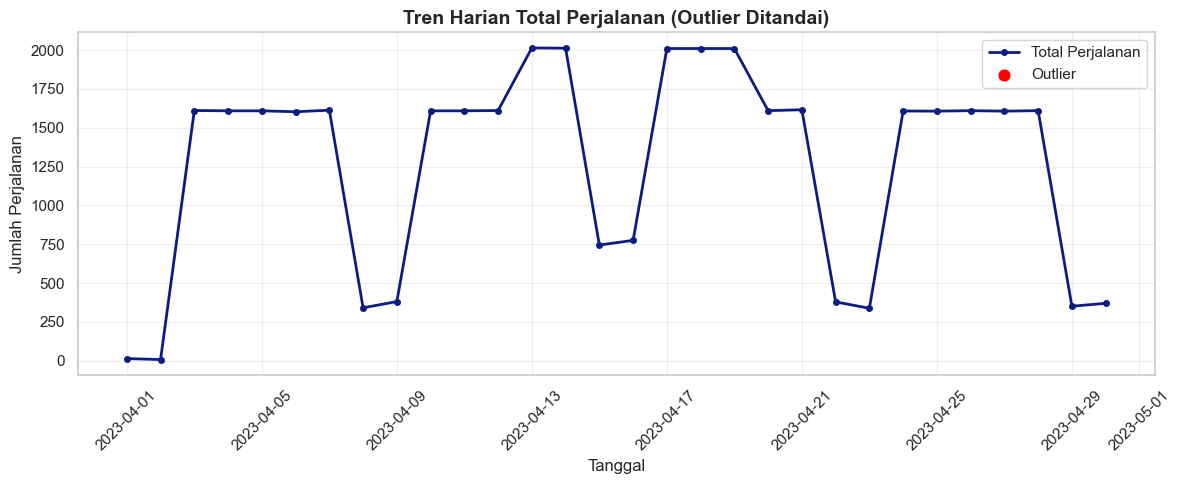

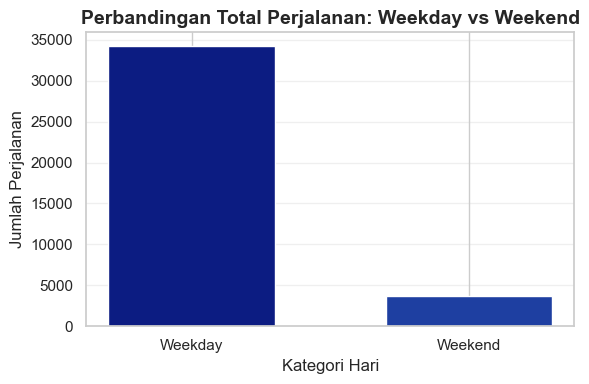

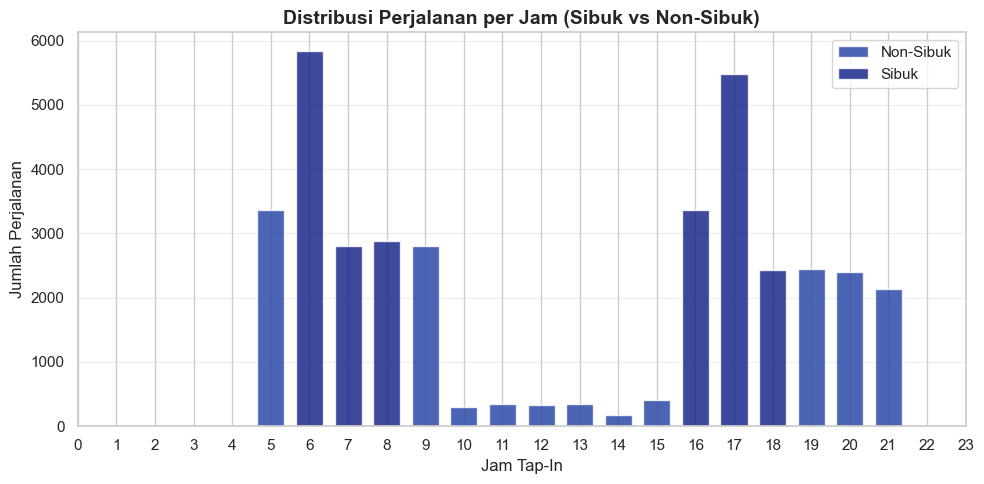

=== Hari dengan Outlier (Total Insiden Tidak Tap-Out) ===
Empty DataFrame
Columns: [tapInDate, total_trip, total_no_tapout, zscore]
Index: []


In [43]:
from scipy.stats import zscore

# --- 1. Persiapan Data Waktu ---
df['tapInDate'] = pd.to_datetime(df['tapInTime']).dt.date
df['tapInHour'] = pd.to_datetime(df['tapInTime']).dt.hour
df['weekday'] = pd.to_datetime(df['tapInTime']).dt.dayofweek  # 0=Senin, 6=Minggu
df['isWeekend'] = df['weekday'].isin([5,6])

# --- 2. Ringkasan Harian ---
daily_summary = df.groupby('tapInDate').agg(
    total_trip=('transID', 'count'),
    total_no_tapout=('isNoTapOut', 'sum')
).reset_index()
daily_summary['proporsi_no_tapout'] = daily_summary['total_no_tapout'] / daily_summary['total_trip']
daily_summary = daily_summary.sort_values('tapInDate')  # urutkan tanggal

# Deteksi Outlier (Z-score & IQR)
daily_summary['zscore'] = zscore(daily_summary['total_no_tapout'])
q1 = daily_summary['total_no_tapout'].quantile(0.25)
q3 = daily_summary['total_no_tapout'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
daily_summary['is_outlier'] = (daily_summary['total_no_tapout'] < lower_bound) | \
                               (daily_summary['total_no_tapout'] > upper_bound)

# --- 3. Ringkasan Weekday vs Weekend ---
weekday_summary = df.groupby('isWeekend').agg(
    total_trip=('transID', 'count'),
    total_no_tapout=('isNoTapOut', 'sum')
).reset_index()
weekday_summary['proporsi_no_tapout'] = weekday_summary['total_no_tapout'] / weekday_summary['total_trip']
weekday_summary['isWeekend'] = weekday_summary['isWeekend'].map({True: 'Weekend', False: 'Weekday'})

# --- 4. Ringkasan Per Jam (Sibuk vs Non-Sibuk) ---
def label_peak(hour):
    if (6 <= hour < 9) or (16 <= hour < 19):
        return 'Sibuk'
    return 'Non-Sibuk'
df['jam_kategori'] = df['tapInHour'].apply(label_peak)
hourly_summary = df.groupby(['tapInHour', 'jam_kategori']).agg(
    total_trip=('transID', 'count'),
    total_no_tapout=('isNoTapOut', 'sum')
).reset_index()
hourly_summary['proporsi_no_tapout'] = hourly_summary['total_no_tapout'] / hourly_summary['total_trip']

# --- Visualisasi Terpisah ---

## (1) Tren Harian dengan Outlier
plt.figure(figsize=(12,5))
plt.plot(daily_summary['tapInDate'], daily_summary['total_trip'],
         color="#0C1C82", linewidth=2, marker='o', markersize=4, label='Total Perjalanan')
plt.scatter(daily_summary.loc[daily_summary['is_outlier'], 'tapInDate'],
            daily_summary.loc[daily_summary['is_outlier'], 'total_trip'],
            color='red', s=60, zorder=5, label='Outlier')
plt.title("Tren Harian Total Perjalanan (Outlier Ditandai)", fontsize=14, weight='bold')
plt.xlabel("Tanggal")
plt.ylabel("Jumlah Perjalanan")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## (2) Weekday vs Weekend
plt.figure(figsize=(6,4))
plt.bar(weekday_summary['isWeekend'], weekday_summary['total_trip'],
        color=['#0C1C82', '#1E3FA1'], width=0.6)
plt.title("Perbandingan Total Perjalanan: Weekday vs Weekend", fontsize=14, weight='bold')
plt.xlabel("Kategori Hari")
plt.ylabel("Jumlah Perjalanan")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## (3) Distribusi Per Jam (Sibuk vs Non-Sibuk)
plt.figure(figsize=(10,5))
colors = {'Sibuk': '#0C1C82', 'Non-Sibuk': '#1E3FA1'}
for kategori in hourly_summary['jam_kategori'].unique():
    subset = hourly_summary[hourly_summary['jam_kategori'] == kategori]
    plt.bar(subset['tapInHour'], subset['total_trip'], color=colors[kategori],
            alpha=0.8, label=kategori, width=0.7)
plt.title("Distribusi Perjalanan per Jam (Sibuk vs Non-Sibuk)", fontsize=14, weight='bold')
plt.xlabel("Jam Tap-In")
plt.ylabel("Jumlah Perjalanan")
plt.xticks(range(0,24))
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# --- Cetak Hari Outlier ---
print("=== Hari dengan Outlier (Total Insiden Tidak Tap-Out) ===")
print(daily_summary[daily_summary['is_outlier']][['tapInDate', 'total_trip', 'total_no_tapout', 'zscore']])


**Analisis Pola Waktu Perjalanan dan Insiden Tidak Tap-Out (April 2023)**

1. **Tren Harian Total Perjalanan**
- Jumlah perjalanan per hari relatif konsisten pada hari kerja (weekday), berkisar antara **1.600–2.000 perjalanan/hari**.  
- Terlihat adanya **penurunan signifikan** pada hari-hari tertentu (kemungkinan akhir pekan), di mana jumlah perjalanan hanya sekitar **300–400 perjalanan/hari**.  
- **Tidak ditemukan outlier signifikan** pada total insiden *tidak tap-out* berdasarkan deteksi Z-score dan IQR. Fluktuasi yang ada lebih disebabkan oleh variasi alami (weekday vs weekend).  

**Insight:**  
Perbedaan yang jelas antara weekday dan weekend menunjukkan pola mobilitas pengguna Transjakarta yang mengikuti pola kerja/kegiatan reguler. Tidak ada hari tertentu dengan anomali ekstrem pada insiden *tidak tap-out*, sehingga gangguan teknis besar tidak terindikasi.


2. **Perbandingan Weekday vs Weekend**
- Volume perjalanan pada **weekday** jauh lebih tinggi dibandingkan **weekend**, sesuai pola komuter (pengguna rutin pada hari kerja).  
- Persentase insiden *tidak tap-out* relatif konsisten di kedua kategori hari, sehingga perbedaan volume lebih dominan daripada perbedaan tingkat insiden.

**Insight:**  
Fokus pemantauan operasional tetap perlu lebih diarahkan ke hari kerja karena volume perjalanan lebih tinggi, meskipun insiden *tidak tap-out* secara proporsional tidak jauh berbeda.


3. **Distribusi Per Jam (Sibuk vs Non-Sibuk)**
- Aktivitas perjalanan meningkat signifikan pada **jam sibuk pagi (06:00–09:00)** dan **sore (16:00–19:00)**.  
- Jam non-sibuk tetap menyumbang perjalanan, tetapi volumenya jauh lebih rendah.  
- Tidak ada lonjakan insiden *tidak tap-out* yang terlihat spesifik di jam tertentu, meski volume tinggi pada jam sibuk dapat meningkatkan potensi kejadian.

**Insight:**  
Jam sibuk menjadi prioritas utama dalam pengawasan sistem (gate, pembaca kartu) karena volume yang tinggi meningkatkan risiko teknis maupun human error. Namun, tidak ada indikasi lonjakan insiden yang signifikan secara statistik pada jam tertentu.


**Kesimpulan Umum Problem 7**
- Perbedaan utama terjadi pada **volume perjalanan** (weekday vs weekend, sibuk vs non-sibuk), bukan pada **proporsi insiden *tidak tap-out***.  
- **Tidak ada hari yang terdeteksi sebagai outlier signifikan** terkait insiden, sehingga insiden cenderung mengikuti volume perjalanan secara proporsional.  
- Fokus perbaikan operasional sebaiknya diarahkan ke periode dengan volume tinggi (weekday, jam sibuk), meskipun insiden relatif stabil secara proporsi.

---

## **Section 5. Conclusion and Recommendation**

**5.1 Conclusion**


1. **Proporsi insiden tidak tap-out rendah dan terkendali**  
   - Dari **37.900 perjalanan di April 2023**, hanya **1.344 kasus (3,55%)** yang tidak tap-out.  
   - **95% CI:** 3,36–3,73%.  
   - **Z-test (Z = -15,30, p < 0,001)** menunjukkan proporsi ini **signifikan lebih rendah dari ambang batas 5%**, menandakan insiden tap-out **terkendali**.

2. **Halte dan koridor tertentu menjadi titik rawan, meski sebagian besar insiden tersebar proporsional**  
   - **Halte Bkn** memiliki **jumlah insiden tertinggi (10 kasus, 5,78%)**, tetapi **tidak signifikan lebih tinggi** dibanding rata-rata halte lain (p = 0,0556).  
   - **Museum Fatahillah (12,7%)**, **Smk 57 (8,0%)**, dan **Puri Beta 2 (7,3%)** menonjol berdasarkan **proporsi insiden**, meskipun volumenya kecil.  
   - **Koridor Kebayoran Lama – Tanah Abang** memiliki **proporsi insiden signifikan (5,41%)** dibanding koridor lain (**p = 0,0308**) setelah data "Tidak Diketahui" dibersihkan.

3. **Segmen pelanggan dan jenis kartu tidak memengaruhi insiden secara signifikan**  
   - **Lansia (4,60%)** dan pengguna **Flazz (3,96%)** memiliki proporsi insiden tertinggi, tetapi **tidak signifikan** (p = 0,053 dan p = 0,093).  
   - **Mayoritas kasus absolut** berasal dari **Dewasa (744 kasus)** dan **JakCard (685 kasus)**, namun ini **sejalan dengan volume perjalanan**.

4. **Jenis layanan bus bukan faktor penentu insiden**  
   - Tidak ada perbedaan signifikan dalam **jumlah absolut maupun proporsi insiden** antara **Mikrotrans, Royaltrans, dan Transjakarta** (p-value semua > 0,3).  
   - Kategori **“Tidak Diketahui”** cenderung menunjukkan **masalah data** (pencatatan rute/layanan), bukan masalah operasional.

5. **Insiden tidak berkaitan dengan error pembayaran**  
   - **Chi-square (p = 0,6299)** dan **Cramér’s V (0,0025)** menunjukkan **hampir tidak ada korelasi** antara insiden *tidak tap-out* dan *error pembayaran*.  
   - Kedua masalah **terjadi independen** dan harus **ditangani terpisah**.

6. **Pola waktu perjalanan mendukung prioritas pemantauan, meski proporsi insiden stabil**  
   - Volume perjalanan **tinggi di weekday (1.600–2.000 perjalanan/hari)** dan **jam sibuk (06:00–09:00, 16:00–19:00)**.  
   - **Weekend turun drastis (300–400 perjalanan/hari)**.  
   - **Proporsi insiden tidak tap-out stabil**, tanpa lonjakan signifikan atau outlier harian.

---

**5.2 Recommendation**


## **Recommendations**

1. **Fokus investigasi pada lokasi dengan proporsi insiden tinggi**  
   - Prioritaskan **Museum Fatahillah (12,7%)**, **Smk 57 (8,0%)**, dan **Puri Beta 2 (7,3%)**.  
   - **Koridor Kebayoran Lama – Tanah Abang** harus menjadi **prioritas audit teknis** karena insidennya **signifikan (5,41%)**.

2. **Perbaiki kualitas data operasional**  
   - Bersihkan kategori **“Tidak Diketahui”** (koridor, jenis layanan).  
   - Pastikan **sinkronisasi log tap-in/tap-out** agar investigasi lokasi error lebih akurat.

3. **Pisahkan penanganan masalah tap-out dan error pembayaran**  
   - Buat **alur investigasi terpisah** karena kedua isu **tidak berkaitan**.  
   - Fokus tap-out pada **perangkat gate & perilaku penumpang**, dan error pembayaran pada **sinkronisasi bank/API**.

4. **Fokus pengawasan pada periode volume tinggi, bukan proporsi insiden**  
   - Tambah **personel monitoring** di **weekday** dan **jam sibuk** (pagi & sore).  
   - Tujuannya mencegah **gangguan massal** meskipun proporsi insiden stabil.

5. **Segmentasi edukasi penumpang untuk kelompok rawan**  
   - **Lansia (4,60%)** dan pengguna **Flazz (3,96%)** bisa mendapat **edukasi khusus** atau **dukungan teknis sederhana** (signage, petugas bantuan).

6. **Monitoring dan analisis lanjutan**  
   - Lakukan **analisis bulanan** untuk deteksi tren (liburan, cuaca, event).  
   - Gunakan **dashboard real-time** agar **anomali bisa cepat ditindak**.

---

## **Keterbatasan Dataset untuk Analisis Tap-Out**

Analisis proporsi dan distribusi insiden **tidak tap-out** pada dataset ini tetap berguna untuk **menemukan pola dan prioritas masalah**, namun ada beberapa keterbatasan yang perlu dicatat agar interpretasi lebih hati-hati:

### **1. Data yang Digunakan Hanya Sampel (1 Bulan)**
- Dataset berisi sekitar **37.900 perjalanan selama 1 bulan**, bukan seluruh transaksi sepanjang tahun.
- Hasil uji hipotesis (Chi-Square dan Z-test) hanya merepresentasikan **sampel**, sehingga tidak selalu dapat digeneralisasi ke populasi (semua perjalanan Transjakarta).

### **2. Perbedaan yang Terlihat Tidak Selalu Signifikan**
- Beberapa kategori seperti **Lansia (4,6%) vs Dewasa (3,5%)** atau **Flazz (3,96%) vs TapCash (2,86%)** menunjukkan perbedaan proporsi.
- Namun, hasil uji statistik menunjukkan **p-value > 0,05**, artinya kita **tidak memiliki bukti cukup kuat** untuk menyimpulkan perbedaan ini signifikan secara statistik.
- Perbedaan bisa terjadi karena **fluktuasi acak** dalam data (random variation) mengingat ukuran sampel kategori tertentu kecil (contoh: hanya 782 perjalanan Lansia).

### **3. Analisis Cenderung Deskriptif**
- Fokus utama dari hasil ini adalah **identifikasi pola, tren waktu, dan area prioritas** (halte dan koridor dengan insiden tertinggi).
- Untuk **membuktikan hubungan sebab-akibat (misalnya, apakah usia atau jenis kartu mempengaruhi risiko insiden)** diperlukan:
  - **Data periode lebih panjang (beberapa bulan).**
  - **Metode analisis lanjutan** seperti *logistic regression* dengan variabel kontrol (koridor, halte, jam).

### **Kesimpulan**
- Analisis tap-out **tetap relevan** sebagai **alat monitoring dan identifikasi masalah operasional**.
- Hasil statistik harus disajikan dengan **konteks keterbatasan**, dan **temuan penting (halte/koridor rawan) tetap bisa menjadi fokus perbaikan teknis**, meskipun uji inferensial belum signifikan.


In [44]:
df.head()

,transID,payCardID,payCardProduct,payCardSex,payCardBirthDate,usia,kategori_usia,corridorName,tapInStopsName,tapInTime,tapInDay,tapOutStopsName,tapOutTime,payAmount,serviceType,isNoTapOutStop,isNoTapOut,isNoPay,isDupTransID,isDupFull,isDupTapIn,durasi_menit,isOvertime,halte_asal,tapInDate,tapInHour,weekday,isWeekend,jam_kategori
0,EIIW227B8L34VB,180062659848800,e-Money,Male,2008,15,Remaja,Matraman Baru - Ancol,Pal Putih,2023-04-03 05:21:44,Senin,Tegalan,2023-04-03 06:00:53,3500.0,Transjakarta,False,False,False,False,False,False,39.150000,False,Pal Putih,2023-04-03,5,0,False,Non-Sibuk
1,LGXO740D2N47GZ,4885331907664776,JakCard,Female,1997,26,Dewasa,Stasiun Tebet - Karet Via Patra Kuningan,Kemenkes 2,2023-04-03 05:42:44,Senin,Sampoerna Strategic,2023-04-03 06:40:01,3500.0,Transjakarta,False,False,False,False,False,False,57.283333,False,Kemenkes 2,2023-04-03,5,0,False,Non-Sibuk
2,DJWR385V2U57TO,4996225095064169,JakCard,Female,1992,31,Dewasa,Pantai Maju - Kota,Gg. Kunir Ii,2023-04-03 05:59:06,Senin,Simpang Kunir Kemukus,2023-04-03 06:50:55,3500.0,Transjakarta,False,False,False,False,False,False,51.816667,False,Gg. Kunir Ii,2023-04-03,5,0,False,Non-Sibuk
3,JTUZ800U7C86EH,639099174703,Flazz,Female,1978,45,Pra-Lansia,Pulo Gebang - Pulo Gadung 2 Via Pik,Taman Elok 1,2023-04-03 05:44:51,Senin,Raya Penggilingan,2023-04-03 06:28:16,3500.0,Transjakarta,False,False,False,False,False,False,43.416667,False,Taman Elok 1,2023-04-03,5,0,False,Non-Sibuk
4,VMLO535V7F95NJ,570928206772,Flazz,Male,1982,41,Pra-Lansia,Tanjung Priok - Pluit,Sunter Boulevard Barat,2023-04-03 06:17:35,Senin,Kali Besar Barat,2023-04-03 06:57:03,3500.0,Transjakarta,False,False,False,False,False,False,39.466667,False,Sunter Boulevard Barat,2023-04-03,6,0,False,Sibuk
